In [1]:
%pip install -e /home/diego/proyectos/vae_AD



Obtaining file:///home/diego/proyectos/vae_AD
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for vae-ad (pyproject.toml) ... done
  Created wheel for vae-ad: filename=vae_ad-0.1.0-0.editable-py3-none-any.whl size=1451 sha256=1b9857e577ceb217ccd4a0db63cc2128e19868c1f467d9ccc8c81301791bb874
  Stored in directory: /tmp/pip-ephem-wheel-cache-9r2gym2o/wheels/61/b9/19/9e9a43f7353c29545b571139844052070562f31c0618dec5ea
Successfully built vae-ad
  Attempting uninstall: vae-ad
    Found existing installation: vae-ad 0.1.0
    Uninstalling vae-ad-0.1.0:
      Successfully uninstalled vae-ad-0.1.0
Note: you may need to restart the kernel to use updated packages.


# Analysis of VAE-Classifier Training Quality Control

**Pipeline:** β-VAE (ConvolutionalVAE) + classical classifiers (AD vs CN) | ADNI multi-site fMRI

**Scope covered (paper-grade):**
- End-to-end artifact provenance + reproducibility manifest
- Pooled OOF performance (ROC/PR + bootstrap CIs)
- Calibration (pooled + per-domain)
- Scanner/confounder leakage diagnostics
- Distribution QC (raw / normalized / reconstructed)
- Information-theoretic analyses (global + latent-dimension profiling)
- Purified-subspace ablation (diagnostic signal vs confounder leakage trade-off)

**Required inputs:**
- `RESULTS_DIR` with fold artifacts from `scripts/run_vae_clf_ad_inference.py`
- `METADATA_PATH` (for confounder/domain analyses)
- `GLOBAL_TENSOR_PATH` (for raw/norm/reconstruction distribution analyses)

**How to run:**
1. Set `RESULTS_DIR` in **Cell §1 — Configuration**.
2. Optionally set `TARGET_CLF`, `N_FOLDS`, `GLOBAL_TENSOR_PATH`, `METADATA_PATH`, `SUMMARY_FILE`.
3. **Kernel → Restart & Run All** (no manual cell ordering).
4. Figures + tables are saved under `OUTPUT_DIR`.

**Notes on interpretation:**
- Domain-level analyses explicitly report low-support/single-class conditions.
- Fold-level inferential tests (N=5) are reported with small-sample caveats.

## §1 — Configuration & Reproducibility

In [2]:
import os
from pathlib import Path

# ============================================================
# USER-EDITABLE BLOCK  (only section that ever needs editing)
# ============================================================

# -- Experiment results folder --
# Can also be set via environment variable VAE_RESULTS_DIR
RESULTS_DIR = Path(
    os.environ.get(
        "VAE_RESULTS_DIR",
        # Example (relative to repo root, edit if needed):
        # "../results/vae_clf_output_v1.8.0"
        str(Path.cwd().parent / "results" / "vae_3channels_beta65_pro"),
    )
).resolve()

# -- Classifier to analyse (must match 'actual_classifier_type' in metrics CSV) --
TARGET_CLF: str = os.environ.get("VAE_TARGET_CLF", "logreg")

# -- Number of outer CV folds --
N_FOLDS: int = int(os.environ.get("VAE_N_FOLDS", "5"))

# -- Global tensor NPZ (set None to skip distribution QC / reconstruction sections) --
# Example: RESULTS_DIR.parent.parent / "data" / "..." / "GLOBAL_TENSOR.npz"
#GLOBAL_TENSOR_PATH: Path | None = None  # set to a Path to enable recon QC
GLOBAL_TENSOR_PATH = RESULTS_DIR.parent.parent / "data" / "AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz"
  #--metadata_path data/SubjectsData_AAL3_procesado2.csv \

# -- Metadata CSV (set None to skip confounder analysis) --
#METADATA_PATH: Path | None = None  # set to a Path to enable confounder analysis
METADATA_PATH = RESULTS_DIR.parent.parent / "data" / "SubjectsData_AAL3_procesado2.csv"

# -- Performance CI bootstrap --
N_BOOT: int = 2000
BOOT_SEED: int = 42

# -- Permutation test (set N_PERM=0 to skip) --
N_PERM: int = 2000
PERM_SEED: int = 42

# -- Output directory for figures + tables --
OUTPUT_DIR: Path = RESULTS_DIR / "training_qc_paper_output"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# -- Specific summary file to pin a run (None = most recent) --
SUMMARY_FILE: str | None = None  # e.g. "summary_metrics_MULTI_logreg_vae....txt"

# ============================================================
print(f"[CONFIG] RESULTS_DIR  = {RESULTS_DIR}")
print(f"[CONFIG] TARGET_CLF   = {TARGET_CLF}")
print(f"[CONFIG] N_FOLDS      = {N_FOLDS}")
print(f"[CONFIG] OUTPUT_DIR   = {OUTPUT_DIR}")
if not RESULTS_DIR.exists():
    import warnings
    warnings.warn(f"RESULTS_DIR does not exist: {RESULTS_DIR}", UserWarning)


[CONFIG] RESULTS_DIR  = /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro
[CONFIG] TARGET_CLF   = logreg
[CONFIG] N_FOLDS      = 5
[CONFIG] OUTPUT_DIR   = /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro/training_qc_paper_output


## §2 — Imports & Style

In [3]:
import sys
import betavae_xai
import betavae_xai.analysis_qc as aq
import betavae_xai.analysis_qc.notebook_utils as nu

print("betavae_xai:", betavae_xai.__file__)
print("analysis_qc:", aq.__file__)
print("notebook_utils:", nu.__file__)
print("has nu.entropy_bits:", hasattr(nu, "entropy_bits"))
print("sys.path[0:5]:", sys.path[:5])


betavae_xai: /home/diego/proyectos/vae_AD/src/betavae_xai/__init__.py
analysis_qc: /home/diego/proyectos/vae_AD/src/betavae_xai/analysis_qc/__init__.py
notebook_utils: /home/diego/proyectos/vae_AD/src/betavae_xai/analysis_qc/notebook_utils.py
has nu.entropy_bits: True
sys.path[0:5]: ['/home/diego/anaconda3/envs/vae_ad/lib/python310.zip', '/home/diego/anaconda3/envs/vae_ad/lib/python3.10', '/home/diego/anaconda3/envs/vae_ad/lib/python3.10/lib-dynload', '', '/home/diego/anaconda3/envs/vae_ad/lib/python3.10/site-packages']


In [4]:
# === Standard library ===
import sys
import warnings
import logging
from typing import Optional

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, message=".*tight_layout.*")
logging.getLogger("matplotlib").setLevel(logging.WARNING)

# === Numerics & data ===
import numpy as np
import pandas as pd
import joblib
from scipy.stats import spearmanr

# === ML / stats ===
from sklearn.metrics import (
    roc_curve, precision_recall_curve,
    roc_auc_score, average_precision_score,
    confusion_matrix,
)
from sklearn.calibration import calibration_curve

# === Plotting ===
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# === Notebook display helpers ===
from IPython.display import display

# Asegura render inline y muestra figuras cuando se crean
%matplotlib inline
#plt.ion()

# Toggle global: ponelo en False si querés sólo guardar a disco
SHOW_FIGURES: bool = True

def show_fig(fig):
    """Muestra una figura en el notebook sin interferir con save_figure()."""
    if SHOW_FIGURES and fig is not None:
        fig.canvas.draw()
        display(fig)

# === Project utilities ===
PROJECT_ROOT = Path.cwd().resolve().parent
SRC_DIR = PROJECT_ROOT / "src"
if SRC_DIR.is_dir() and str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))


from betavae_xai.analysis_qc.notebook_utils import (
    entropy_bits, conditional_entropy_bits, mi_bits, nmi,
    cramers_v_bias_corrected, domain_support_report
)

from betavae_xai.analysis_qc import (
    # Calibration
    reliability_report, weighted_ece_mce,
    # Visualization
    set_publication_style, create_color_palette, save_figure,
    # Pipeline management
    infer_run_tag, load_run_args, resolve_artifacts, load_predictions,
    # Performance
    bootstrap_auc_ci, bootstrap_prauc_ci,
    # Stats
    stratified_permutation_auc, exact_sign_permutation_test,
    # Metadata
    build_metadata_aligned_to_tensor, detect_confounder_column,
    # Provenance
    save_run_manifest,
    # Normalization (for reconstruction QC)
    apply_norm_batch,
)

set_publication_style("paper")
COLORS = create_color_palette("diagnostic")
FIG_FORMATS = ["png", "pdf"]

print("[OK] All imports successful.")


[OK] All imports successful.


## §3 — Pipeline Provenance Map

The table below maps each artifact consumed by this notebook to its producer
(script + function) in `scripts/run_vae_clf_ad_inference.py`.

| Artifact | Producer (file → function) | Notes |
|---|---|---|
| `summary_metrics_MULTI_*.txt` | `run_vae_clf_ad_inference.py` → `train_and_evaluate_pipeline` | Run args + per-clf mean metrics |
| `all_folds_metrics_MULTI_*.csv` | same → `metrics_df.to_csv(...)` | One row per fold × classifier |
| `all_folds_clf_predictions_MULTI_*.joblib` | same → `joblib.dump(all_folds_clf_predictions, ...)` | list[DataFrame]: SubjectID, y_true, y_score_*, fold |
| `all_folds_vae_training_history_*.joblib` | same → `joblib.dump(all_folds_vae_history, ...)` | list[dict]: train/val loss, KLD, beta per epoch |
| `fold_k/vae_model_fold_k.pt` | same → `torch.save(vae_fold_k.state_dict(), ...)` | Best VAE weights (early stopping on val_loss_betaMax) |
| `fold_k/vae_norm_params.joblib` | same → `joblib.dump(norm_params_fold_list, ...)` | list[dict] per channel: mode, mean/std or min/max |
| `fold_k/latent_qc_metrics.csv` | same → `qc_latent_df.to_csv(...)` | silhouette_latent, acc_site_raw, acc_site_latent, n_sites |
| `fold_k/fold_k_scanner_leakage.csv` | `analysis_qc.fold_qc.evaluate_scanner_leakage` | Balanced accuracy predicting scanner from connectome vs latent |
| `fold_k/fold_k_dist_raw.csv` | `analysis_qc.fold_qc.summarize_distribution_stages` | Per-channel off-diagonal stats (raw values) |
| `fold_k/fold_k_dist_norm.csv` | same | Same after z-score/minmax normalization |
| `fold_k/fold_k_dist_recon.csv` | same | Same on VAE reconstructions |
| `fold_k/vae_train_history_fold_k.joblib` | same → `joblib.dump(history_data, ...)` | Single-fold history dict |
| `fold_k/train_dev_subjects_fold.csv` | same → `train_dev_df_fold.to_csv(...)` | SubjectID + tensor_idx for train/dev split |
| `fold_k/test_subjects_fold.csv` | same | SubjectID + tensor_idx for test split |

**Channel mapping** (default, 7 channels, shape N×7×131×131):

| Index | Name | Description |
|---|---|---|
| 0 | Pearson_OMST_GCE_Signed_Weighted | Pearson FC + OMST graph-theoretic edge selection |
| 1 | Pearson_Full_FisherZ_Signed | Full Pearson FC, Fisher-z transformed |
| 2 | MI_KNN_Symmetric | Mutual information (k-NN estimator, symmetrised) |
| 3 | dFC_AbsDiffMean | Dynamic FC – mean abs deviation across windows |
| 4 | dFC_StdDev | Dynamic FC – std deviation across windows |
| 5 | DistanceCorr | Distance correlation (nonlinear dependency) |
| 6 | Granger_F_lag1 | Granger causality F-statistic (lag 1, directional) |


## §3b — Legacy vs Paper Audit Checklist

The checklist below was built by inspecting both notebooks:
- legacy: `notebooks/04_training_qc.ipynb`
- paper: `notebooks/04_training_qc_paper.ipynb`

| Analysis block / feature | Present in paper notebook? | Present in legacy notebook? |
|---|---:|---:|
| Pooled ROC/PR + bootstrap CI | Y | Y |
| Calibration (pooled) | Y | Y |
| Calibration by confounder/domain | Y | Y |
| Scanner leakage summary + sign-flip test | Y | Y |
| Distribution QC from fold CSVs (raw/norm/recon) | Y | Y |
| Confounder-only OOF baseline (`conf` vs `score` vs `score+conf`) | N | Y |
| Tail-mass QC raw vs fold-normalized (percentiles + tails) | N | Y |
| Reconstruction saturation QC from VAE forward pass | N | Y |
| Latent MI per-dimension profiling (IY vs IS, purity, diff) | N | Y |
| Purified-subspace ablation (full-Z vs top-K clean dims) | N | Y |
| Outputs index (all generated files under OUTPUT_DIR) | N | Y (partial/mixed) |

Planned add-ons in this notebook (high-priority): 1) confounder-only OOF baselines, 2) tail-mass QC, 3) reconstruction saturation, 4) latent MI per-dimension profile, 5) purified-subspace ablation.

## §4 — Artifact Loading & Sanity Checks

In [5]:
# ── 4a. Infer RUN_TAG from summary file ──────────────────────────────────────
RUN_TAG, SUMMARY_PATH = infer_run_tag(RESULTS_DIR, summary_file=SUMMARY_FILE)
print(f"[OK] RUN_TAG = {RUN_TAG}")
print(f"[OK] Summary = {SUMMARY_PATH.name}")

# ── 4b. Load run arguments ───────────────────────────────────────────────────
run_args = load_run_args(SUMMARY_PATH)
print(f"[OK] run_args loaded ({len(run_args)} keys). "
      f"outer_folds={run_args.get('outer_folds', N_FOLDS)}, "
      f"latent_dim={run_args.get('latent_dim', '?')}, "
      f"beta_vae={run_args.get('beta_vae', '?')}")

# Override N_FOLDS from run_args if available
_n_folds_from_args = run_args.get("outer_folds", None)
if _n_folds_from_args and int(_n_folds_from_args) != N_FOLDS:
    print(f"[INFO] Overriding N_FOLDS: {N_FOLDS} → {int(_n_folds_from_args)} (from run_args)")
    N_FOLDS = int(_n_folds_from_args)

# ── 4c. Resolve all artifact paths ──────────────────────────────────────────
artifacts = resolve_artifacts(RESULTS_DIR, RUN_TAG, N_FOLDS)
print(f"[OK] metrics_csv  : {artifacts['metrics_csv'].name}")
print(f"[OK] pred_joblib  : {artifacts['pred_joblib'].name}")
if artifacts["vae_history_joblib"]:
    print(f"[OK] vae_history  : {artifacts['vae_history_joblib'].name}")
else:
    print("[WARN] all_folds_vae_training_history_*.joblib not found — VAE dynamics section skipped.")

for k in range(1, N_FOLDS + 1):
    pf = artifacts["per_fold"][k]
    found = [name for name, p in pf.items() if name != "dir" and p is not None]
    print(f"  fold_{k}: {', '.join(found)}")

# ── 4d. Load metrics DataFrame ──────────────────────────────────────────────
metrics_df = pd.read_csv(artifacts["metrics_csv"])
print(f"\n[OK] metrics_df shape: {metrics_df.shape}")
print(f"     classifiers: {metrics_df['actual_classifier_type'].unique().tolist()}")

# Filter to TARGET_CLF
m_clf = metrics_df[metrics_df["actual_classifier_type"] == TARGET_CLF].copy()
if m_clf.empty:
    available = metrics_df["actual_classifier_type"].unique().tolist()
    raise ValueError(
        f"No rows for TARGET_CLF='{TARGET_CLF}'. Available: {available}. "
        f"Update TARGET_CLF in §1."
    )
m_clf["fold"] = pd.to_numeric(m_clf["fold"], errors="coerce").astype(int)
print(f"[OK] m_clf ({TARGET_CLF}): {len(m_clf)} folds")

# ── 4e. Load VAE training histories ─────────────────────────────────────────
vae_histories = None
if artifacts["vae_history_joblib"] is not None:
    vae_histories = joblib.load(artifacts["vae_history_joblib"])
    print(f"[OK] vae_histories: {len(vae_histories)} entries")

# ── 4f. Load per-fold QC metrics ────────────────────────────────────────────
qc_latent_list, leak_list = [], []
dist_raw_list, dist_norm_list, dist_recon_list = [], [], []

for k in range(1, N_FOLDS + 1):
    pf = artifacts["per_fold"][k]

    if pf["latent_qc"] is not None:
        _df = pd.read_csv(pf["latent_qc"]); _df["fold"] = k
        qc_latent_list.append(_df)

    for lst, key in [(dist_raw_list, "dist_raw"), (dist_norm_list, "dist_norm"),
                     (dist_recon_list, "dist_recon")]:
        if pf[key] is not None:
            _df = pd.read_csv(pf[key]); _df["fold"] = k; lst.append(_df)

    # scanner leakage: try per-fold CSV (various naming conventions)
    leak_path = pf["scanner_leakage"]
    if leak_path is None:
        # try alternate name
        for alt in [f"fold_{k}_test_scanner_leakage.csv", "scanner_leakage.csv"]:
            _alt = pf["dir"] / alt
            if _alt.exists():
                leak_path = _alt; break
    if leak_path is not None:
        _df = pd.read_csv(leak_path); _df["fold"] = k; leak_list.append(_df)

qc_latent = pd.concat(qc_latent_list, ignore_index=True) if qc_latent_list else None
leak_df   = pd.concat(leak_list,     ignore_index=True) if leak_list   else None
dist_raw_all  = pd.concat(dist_raw_list,  ignore_index=True) if dist_raw_list  else None
dist_norm_all = pd.concat(dist_norm_list, ignore_index=True) if dist_norm_list else None
dist_recon_all= pd.concat(dist_recon_list,ignore_index=True) if dist_recon_list else None

print(f"\n[Sanity] qc_latent:   {qc_latent.shape if qc_latent is not None else 'None'}")
print(f"[Sanity] leak_df:      {leak_df.shape if leak_df is not None else 'None'}")
print(f"[Sanity] dist_raw_all: {dist_raw_all.shape if dist_raw_all is not None else 'None'}")


# Initialise metadata variables (populated in §9b if METADATA_PATH is set)
_meta = None


[OK] RUN_TAG = svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.15_ln0_outer5x1_scoreroc_auc
[OK] Summary = summary_metrics_MULTI_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.15_ln0_outer5x1_scoreroc_auc.txt
[OK] run_args loaded (59 keys). outer_folds=5, latent_dim=256, beta_vae=6.5
[OK] metrics_csv  : all_folds_metrics_MULTI_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.15_ln0_outer5x1_scoreroc_auc.csv
[OK] pred_joblib  : all_folds_clf_predictions_MULTI_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.15_ln0_outer5x1_scoreroc_auc.joblib
[OK] vae_history  : all_folds_vae_training_history_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.15_ln0_outer5x1_scoreroc_auc.joblib
  fold_1: latent_qc, dist_raw, dist_norm, dist_recon, scanner_leakage, vae_train_history, norm_params
  fold_2: latent_qc, dist_raw, dist_norm, dist

In [6]:
# ── 4g. Load pooled predictions ──────────────────────────────────────────────
preds_df = load_predictions(artifacts["pred_joblib"], TARGET_CLF, n_folds=N_FOLDS)
print(f"[OK] preds_df shape: {preds_df.shape}")
print(f"     folds found: {sorted(preds_df['fold'].dropna().unique().tolist())}")
print(f"     columns: {preds_df.columns.tolist()}")

# Ensure y_true is int and we have a valid score column
assert "y_true" in preds_df.columns, "Missing 'y_true' in predictions"
assert "y_score_final" in preds_df.columns, "Missing 'y_score_final' in predictions"

y_true_pooled  = preds_df["y_true"].values.astype(int)
y_score_pooled = preds_df["y_score_final"].values.astype(float)

print(f"\n[Sanity] N_test_pooled = {len(y_true_pooled)}, "
      f"AD={int((y_true_pooled==1).sum())}, CN={int((y_true_pooled==0).sum())}")


[OK] preds_df shape: (183, 10)
     folds found: [1, 2, 3, 4, 5]
     columns: ['fold', 'classifier_type', 'SubjectID', 'tensor_idx', 'y_true', 'y_score_raw', 'y_score_cal', 'y_score_final', 'y_pred', 'did_calibrate']

[Sanity] N_test_pooled = 183, AD=94, CN=89


## §4b — Unified Metadata Alignment (single source of truth)

This is the only metadata-loading/alignment block used by downstream confounder analyses.
It builds a single `master_df` (OOF predictions + aligned metadata), creates a consistent confounder column,
and collapses rare categories for small-sample robustness.

In [7]:
# Single-source metadata block reused by all downstream sections
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import wilcoxon

MIN_N_DOMAIN = int(os.environ.get("VAE_MIN_N_DOMAIN", "6"))

_meta = None
if METADATA_PATH is not None and Path(METADATA_PATH).exists():
    _meta = pd.read_csv(METADATA_PATH)
    print(f"[OK] metadata loaded once: {_meta.shape}")
else:
    print("[WARN] METADATA_PATH missing; confounder-specific sections will be skipped.")

master_df = preds_df.copy()
master_df["_y"] = master_df["y_true"].astype(int)
master_df["_p"] = master_df["y_score_final"].astype(float)

ID_COL = None
CONFOUNDER_COL = None
if _meta is not None:
    CONFOUNDER_COL = detect_confounder_column(_meta)
    ID_COL = next((c for c in ["SubjectID", "RID", "participant_id", "ID"] if c in _meta.columns), None)
    if ID_COL is not None and "SubjectID" in master_df.columns and CONFOUNDER_COL is not None:
        master_df = master_df.merge(
            _meta[[ID_COL, CONFOUNDER_COL]].rename(columns={ID_COL: "SubjectID"}),
            on="SubjectID",
            how="left",
        )
        master_df["_confounder"] = master_df[CONFOUNDER_COL].fillna("Unknown").astype(str)
    else:
        master_df["_confounder"] = "Unknown"
else:
    master_df["_confounder"] = "Unknown"

vc_conf = master_df["_confounder"].value_counts(dropna=False)
keep_domains = vc_conf[vc_conf >= MIN_N_DOMAIN].index.tolist()
master_df["_confounder_collapsed"] = master_df["_confounder"].where(
    master_df["_confounder"].isin(keep_domains), "Other"
)

print(f"[INFO] Confounder column: {CONFOUNDER_COL}")
print(f"[INFO] Domain cardinality raw/collapsed: {master_df['_confounder'].nunique()} / {master_df['_confounder_collapsed'].nunique()}")
print(f"[INFO] Missing confounder ratio: {master_df['_confounder'].eq('Unknown').mean():.3f}")

# Save support tables (paper traceability)
ct_diag_conf = pd.crosstab(master_df["_confounder_collapsed"], master_df["_y"]).rename(columns={0: "CN", 1: "AD"})
support_df = domain_support_report(master_df, dom_col="_confounder_collapsed", y_col="_y")
ct_diag_conf.to_csv(OUTPUT_DIR / f"table_crosstab_diag_by_domain_{TARGET_CLF}_{RUN_TAG}.csv")
support_df.to_csv(OUTPUT_DIR / f"table_domain_support_collapsed_{TARGET_CLF}_{RUN_TAG}.csv", index=False)
print("[OK] Saved unified support tables.")

[OK] metadata loaded once: (434, 33)
[INFO] Confounder column: Manufacturer
[INFO] Domain cardinality raw/collapsed: 3 / 3
[INFO] Missing confounder ratio: 0.000
[OK] Saved unified support tables.


## §5 — Run Manifest (Provenance Record)

In [8]:
manifest = save_run_manifest(
    out_dir=OUTPUT_DIR,
    results_dir=RESULTS_DIR,
    run_tag=RUN_TAG,
    summary_file=SUMMARY_PATH.name,
    run_args=run_args,
    artifacts=artifacts,
    extra={
        "TARGET_CLF": TARGET_CLF,
        "N_FOLDS": N_FOLDS,
        "N_BOOT": N_BOOT,
        "N_PERM": N_PERM,
    },
)

# Print human-readable summary
print("=== RUN MANIFEST ===")
print(f"  RESULTS_DIR : {manifest['results_dir']}")
print(f"  RUN_TAG     : {manifest['run_tag']}")
print(f"  git_commit  : {manifest.get('git_commit', 'N/A')}")
print(f"  summary     : {manifest['summary_file_used']}")
key_args = ["outer_folds","latent_dim","beta_vae","norm_mode","decoder_type","classifier_types"]
for k in key_args:
    v = manifest["run_args"].get(k, "N/A")
    print(f"  {k:<22}: {v}")
print(f"\nManifest saved to: {OUTPUT_DIR / 'run_manifest.json'}")


=== RUN MANIFEST ===
  RESULTS_DIR : /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro
  RUN_TAG     : svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.15_ln0_outer5x1_scoreroc_auc
  git_commit  : 37c2790
  summary     : summary_metrics_MULTI_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.15_ln0_outer5x1_scoreroc_auc.txt
  outer_folds           : 5
  latent_dim            : 256
  beta_vae              : 6.5
  norm_mode             : zscore_offdiag
  decoder_type          : convtranspose
  classifier_types      : ['svm', 'logreg']

Manifest saved to: /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro/training_qc_paper_output/run_manifest.json


### §5b — Fold-Level Summary Table

In [9]:
# Build master summary table (metrics + latent QC per fold)
df_summary = m_clf[["fold","auc","auc_final","auc_raw","pr_auc","pr_auc_final",
                     "balanced_accuracy","sensitivity","specificity","f1_score"]].copy()

# Merge latent QC
if qc_latent is not None:
    _qc = qc_latent[["fold","silhouette_latent","acc_site_latent","acc_site_raw",
                      "n_sites","chance_level"]].copy()
    df_summary = df_summary.merge(_qc, on="fold", how="left")

# Core metric columns (present-only subset)
_metric_cols = [c for c in ["auc_final","pr_auc_final","balanced_accuracy",
                              "sensitivity","specificity","f1_score",
                              "silhouette_latent","acc_site_latent","acc_site_raw"]
                if c in df_summary.columns and df_summary[c].notna().any()]

display_df = df_summary[["fold"] + _metric_cols].set_index("fold")
print("=== Per-fold metrics ===")
print(display_df.round(4).to_string())

# Global summary
print("\n=== Global (mean ± SD) ===")
global_stats = display_df[_metric_cols].agg(["mean","std"]).T
global_stats.columns = ["mean","sd"]
print(global_stats.round(4).to_string())

# Export
display_df.reset_index().to_csv(OUTPUT_DIR / f"table_fold_metrics_{TARGET_CLF}.csv", index=False)
global_stats.to_csv(OUTPUT_DIR / f"table_global_stats_{TARGET_CLF}.csv")

# LaTeX
with open(OUTPUT_DIR / f"table_fold_metrics_{TARGET_CLF}.tex", "w") as f:
    f.write(display_df.round(4).to_latex(escape=False,
            caption=f"Per-fold metrics ({TARGET_CLF.upper()}, {RUN_TAG})",
            label=f"tab:fold_metrics_{TARGET_CLF}"))
print(f"\n[OK] Tables saved to {OUTPUT_DIR}")


=== Per-fold metrics ===
      auc_final  pr_auc_final  balanced_accuracy  sensitivity  specificity  f1_score  silhouette_latent  acc_site_latent  acc_site_raw
fold                                                                                                                                  
1        0.8860        0.8746             0.7851       0.7368       0.8333    0.7778             0.0296              NaN           NaN
2        0.8187        0.8677             0.7822       0.8421       0.7222    0.8000             0.0166              NaN           NaN
3        0.8567        0.8824             0.7295       0.7368       0.7222    0.7368             0.0245           0.5556        0.5417
4        0.7994        0.8114             0.7222       0.9444       0.5000    0.7727             0.0098           0.4901        0.5278
5        0.8452        0.8915             0.7740       0.8421       0.7059    0.8000             0.0120           0.5575        0.5417

=== Global (mean ± SD) ===
  

## §6 — Distribution QC (Raw / Normalized / Reconstructed)

Off-diagonal connectivity values from the global tensor at three stages:
raw (original scale), normalized (per-channel z-score or min-max off-diagonal),
and reconstructed (VAE output). Each row corresponds to one fold × channel.

> **Expected:** normalized values should be approximately standard-normal;
> reconstructed values should be within the decoder's output range (tanh: [−1,1]).


=== Raw distribution (mean of off-diagonal values across folds) ===
                                    mean             std        
                                    mean     std    mean     std
channel                                                         
MI_KNN_Symmetric                  0.0570  0.0022  0.8143  0.0016
Pearson_Full_FisherZ_Signed      -0.0474  0.0020  0.7771  0.0023
Pearson_OMST_GCE_Signed_Weighted  0.3094  0.0009  1.0917  0.0025

=== Normalized distribution ===
                                 mean       std     
                                 mean  std mean  std
channel                                             
MI_KNN_Symmetric                  0.0  0.0  1.0  0.0
Pearson_Full_FisherZ_Signed       0.0  0.0  1.0  0.0
Pearson_OMST_GCE_Signed_Weighted -0.0  0.0  1.0  0.0


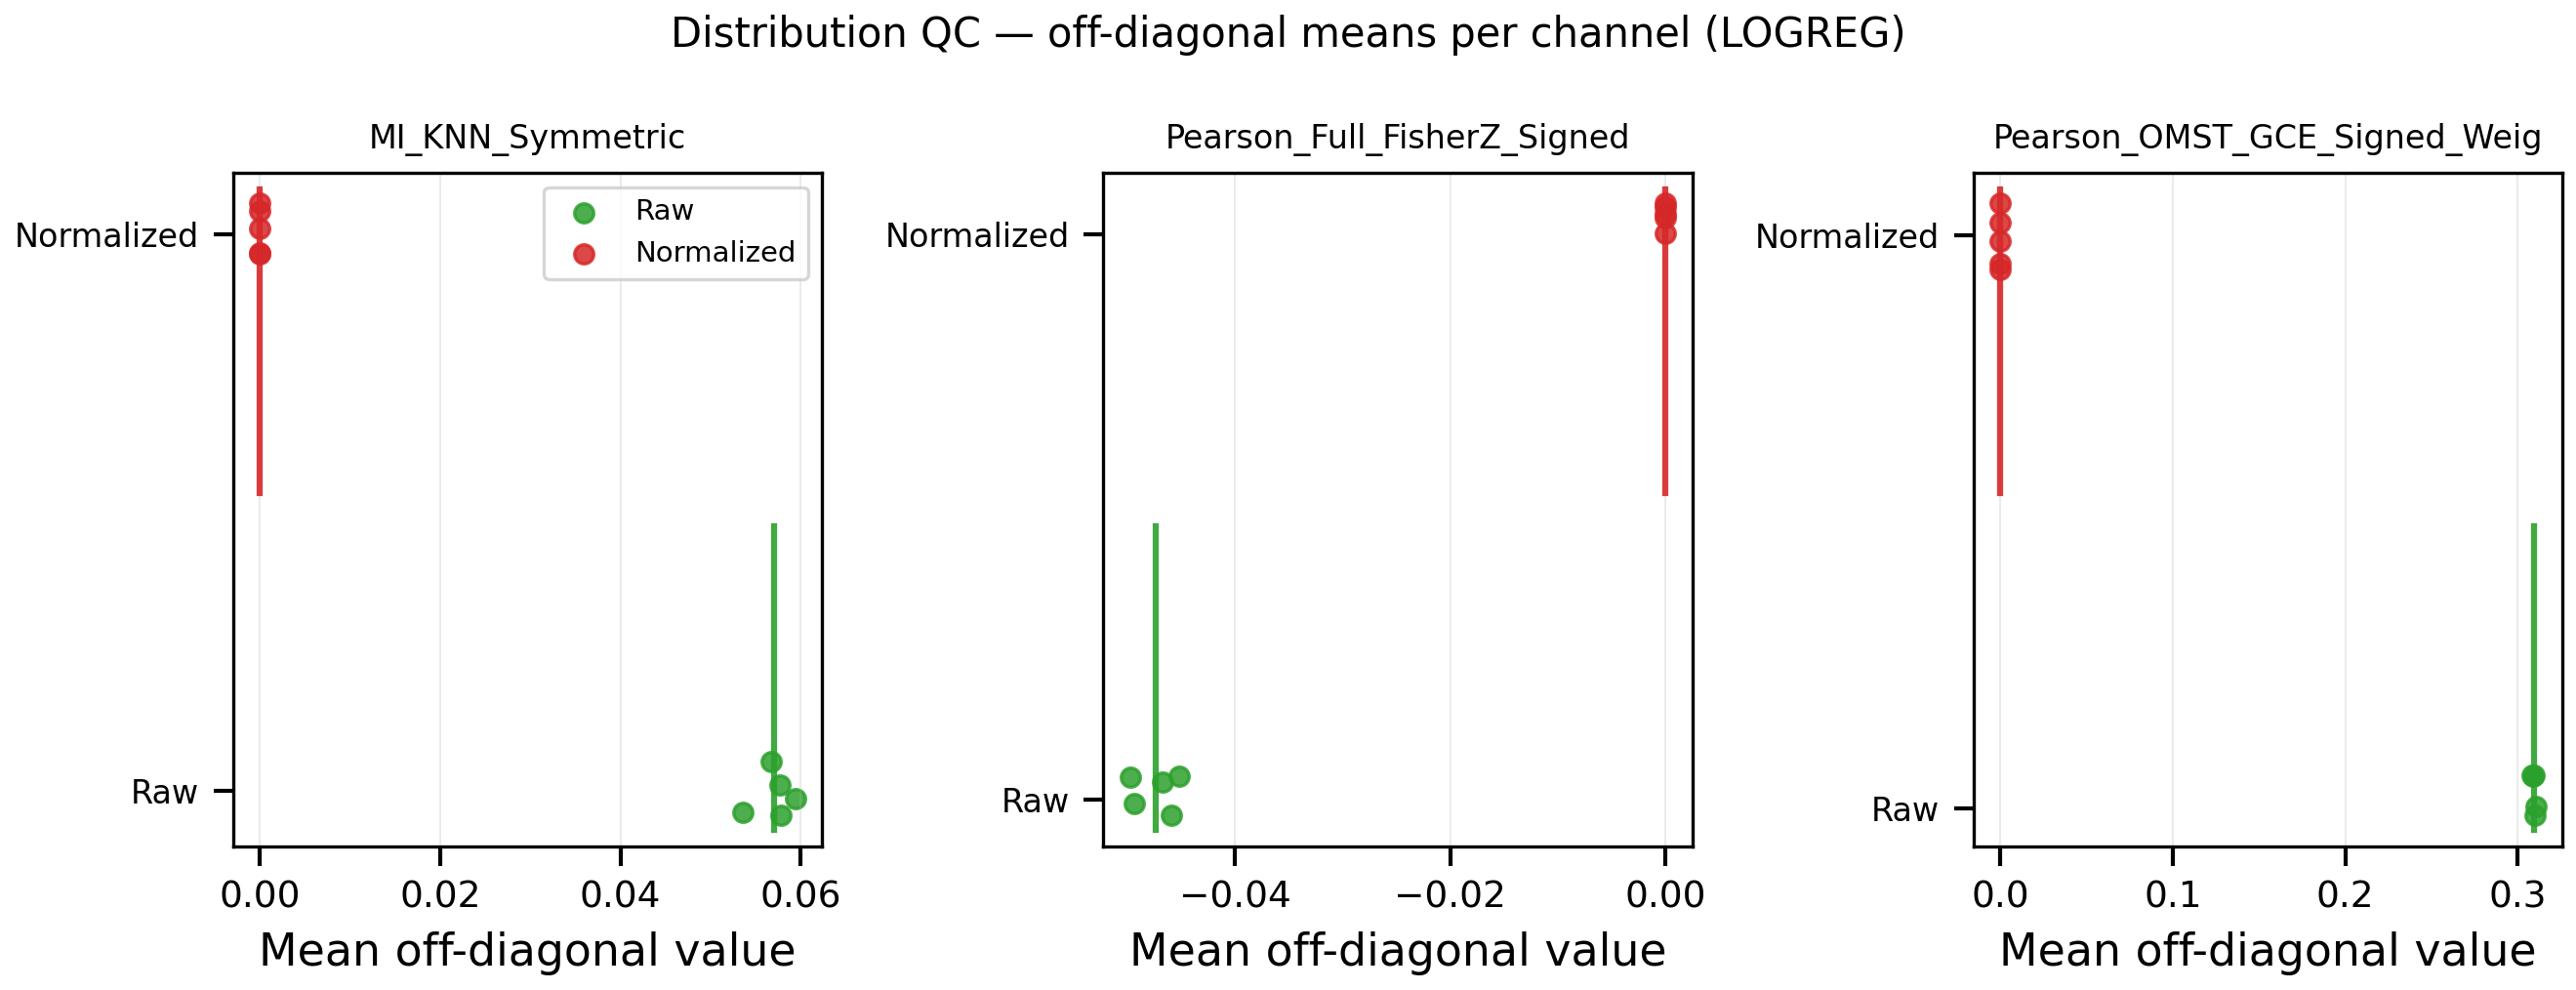

Saved: /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro/training_qc_paper_output/fig_distribution_qc_logreg_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.png
Saved: /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro/training_qc_paper_output/fig_distribution_qc_logreg_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.pdf
[OK] Distribution QC figure saved.


In [10]:
if dist_raw_all is None:
    print("[SKIP] No distribution QC CSVs found. "
          "Re-run pipeline with --qc_analyze_distributions.")
else:
    # ── Detect channel column ────────────────────────────────────────────────
    ch_col = next((c for c in ["channel","channel_name","chan"] if c in dist_raw_all.columns), None)
    if ch_col is None:
        dist_raw_all["channel"] = "unknown"; ch_col = "channel"

    # ── Detect stat columns (mean, std, median) ──────────────────────────────
    def _find_col(df, tokens):
        for c in df.columns:
            if any(t in c.lower() for t in tokens):
                return c
        return None

    raw_mean_col  = _find_col(dist_raw_all,  ["mean"])
    raw_std_col   = _find_col(dist_raw_all,  ["std"])
    norm_mean_col = _find_col(dist_norm_all, ["mean"]) if dist_norm_all is not None else None
    norm_std_col  = _find_col(dist_norm_all, ["std"])  if dist_norm_all is not None else None

    # ── Aggregate across folds ───────────────────────────────────────────────
    def agg_dist(df, mean_col, std_col, ch_col):
        if mean_col is None:
            return None
        return (df.groupby(ch_col)[[mean_col, std_col]]
                  .agg(["mean","std"])
                  .round(4))

    dist_agg_raw  = agg_dist(dist_raw_all,  raw_mean_col,  raw_std_col,  ch_col)
    dist_agg_norm = agg_dist(dist_norm_all, norm_mean_col, norm_std_col, ch_col) if dist_norm_all is not None else None

    if dist_agg_raw is not None:
        print("=== Raw distribution (mean of off-diagonal values across folds) ===")
        print(dist_agg_raw.to_string())

    if dist_agg_norm is not None:
        print("\n=== Normalized distribution ===")
        print(dist_agg_norm.to_string())

    # ── Figure: distributions per stage ─────────────────────────────────────
    stages = []
    if dist_raw_all is not None and raw_mean_col is not None:
        stages.append(("Raw", dist_raw_all, raw_mean_col, COLORS.get("CN","#7f7f7f")))
    if dist_norm_all is not None and norm_mean_col is not None:
        stages.append(("Normalized", dist_norm_all, norm_mean_col, COLORS.get("AD","#1f77b4")))

    if stages:
        channels = sorted(dist_raw_all[ch_col].unique())
        n_ch = len(channels)
        fig, axes = plt.subplots(1, max(n_ch,1), figsize=(3*max(n_ch,1), 3.5), sharey=False)
        if n_ch == 1:
            axes = [axes]

        # Con N=5 folds, histograma suele ser poco informativo y puede “verse vacío”.
        # Cambiamos a strip/scatter por etapa.
        stage_names = [s[0] for s in stages]  # ["Raw", "Normalized", ...]
        for ax, ch in zip(axes, channels):
            for j, (label, df_s, mc, color) in enumerate(stages):
                vals = df_s.loc[df_s[ch_col] == ch, mc].dropna().to_numpy()
                if len(vals) == 0:
                    continue
                # jitter vertical para que no se pisen
                y = j + (np.random.rand(len(vals)) - 0.5) * 0.12
                ax.scatter(vals, y, s=22, alpha=0.85, color=color,
                           label=label if ax == axes[0] else None)
                # marca de media
                ax.axvline(float(np.mean(vals)), ymin=(j+0.05)/len(stages), ymax=(j+0.95)/len(stages),
                           color=color, lw=1.5, alpha=0.9)
            ax.set_title(str(ch)[:28], fontsize=8)
            ax.set_xlabel("Mean off-diagonal value")
            ax.set_yticks(range(len(stage_names)))
            ax.set_yticklabels(stage_names, fontsize=8)
            if ax == axes[0]:
                ax.legend(fontsize=7, loc="best")
            ax.grid(True, axis="x", alpha=0.25)

        fig.suptitle(f"Distribution QC — off-diagonal means per channel ({TARGET_CLF.upper()})", fontsize=10)
        plt.tight_layout()
        show_fig(fig)          # <-- display en notebook
                   # <-- flush (opcional pero útil)
        save_figure(fig, OUTPUT_DIR / f"fig_distribution_qc_{TARGET_CLF}_{RUN_TAG}", formats=FIG_FORMATS)
        print(f"[OK] Distribution QC figure saved.")
    else:
        print("[SKIP] No column data to plot.")


## §7 — Performance Analysis

Pooled out-of-fold (OOF) predictions across all outer CV folds.
Bootstrap 95% CIs computed with `N_BOOT` resamples (configured in §1).


Pooled OOF  (N=183, prev=0.51)
  ROC-AUC  = 0.8249  95% CI [0.7595, 0.8808]
  PR-AUC   = 0.8362  95% CI [0.7590, 0.8974]


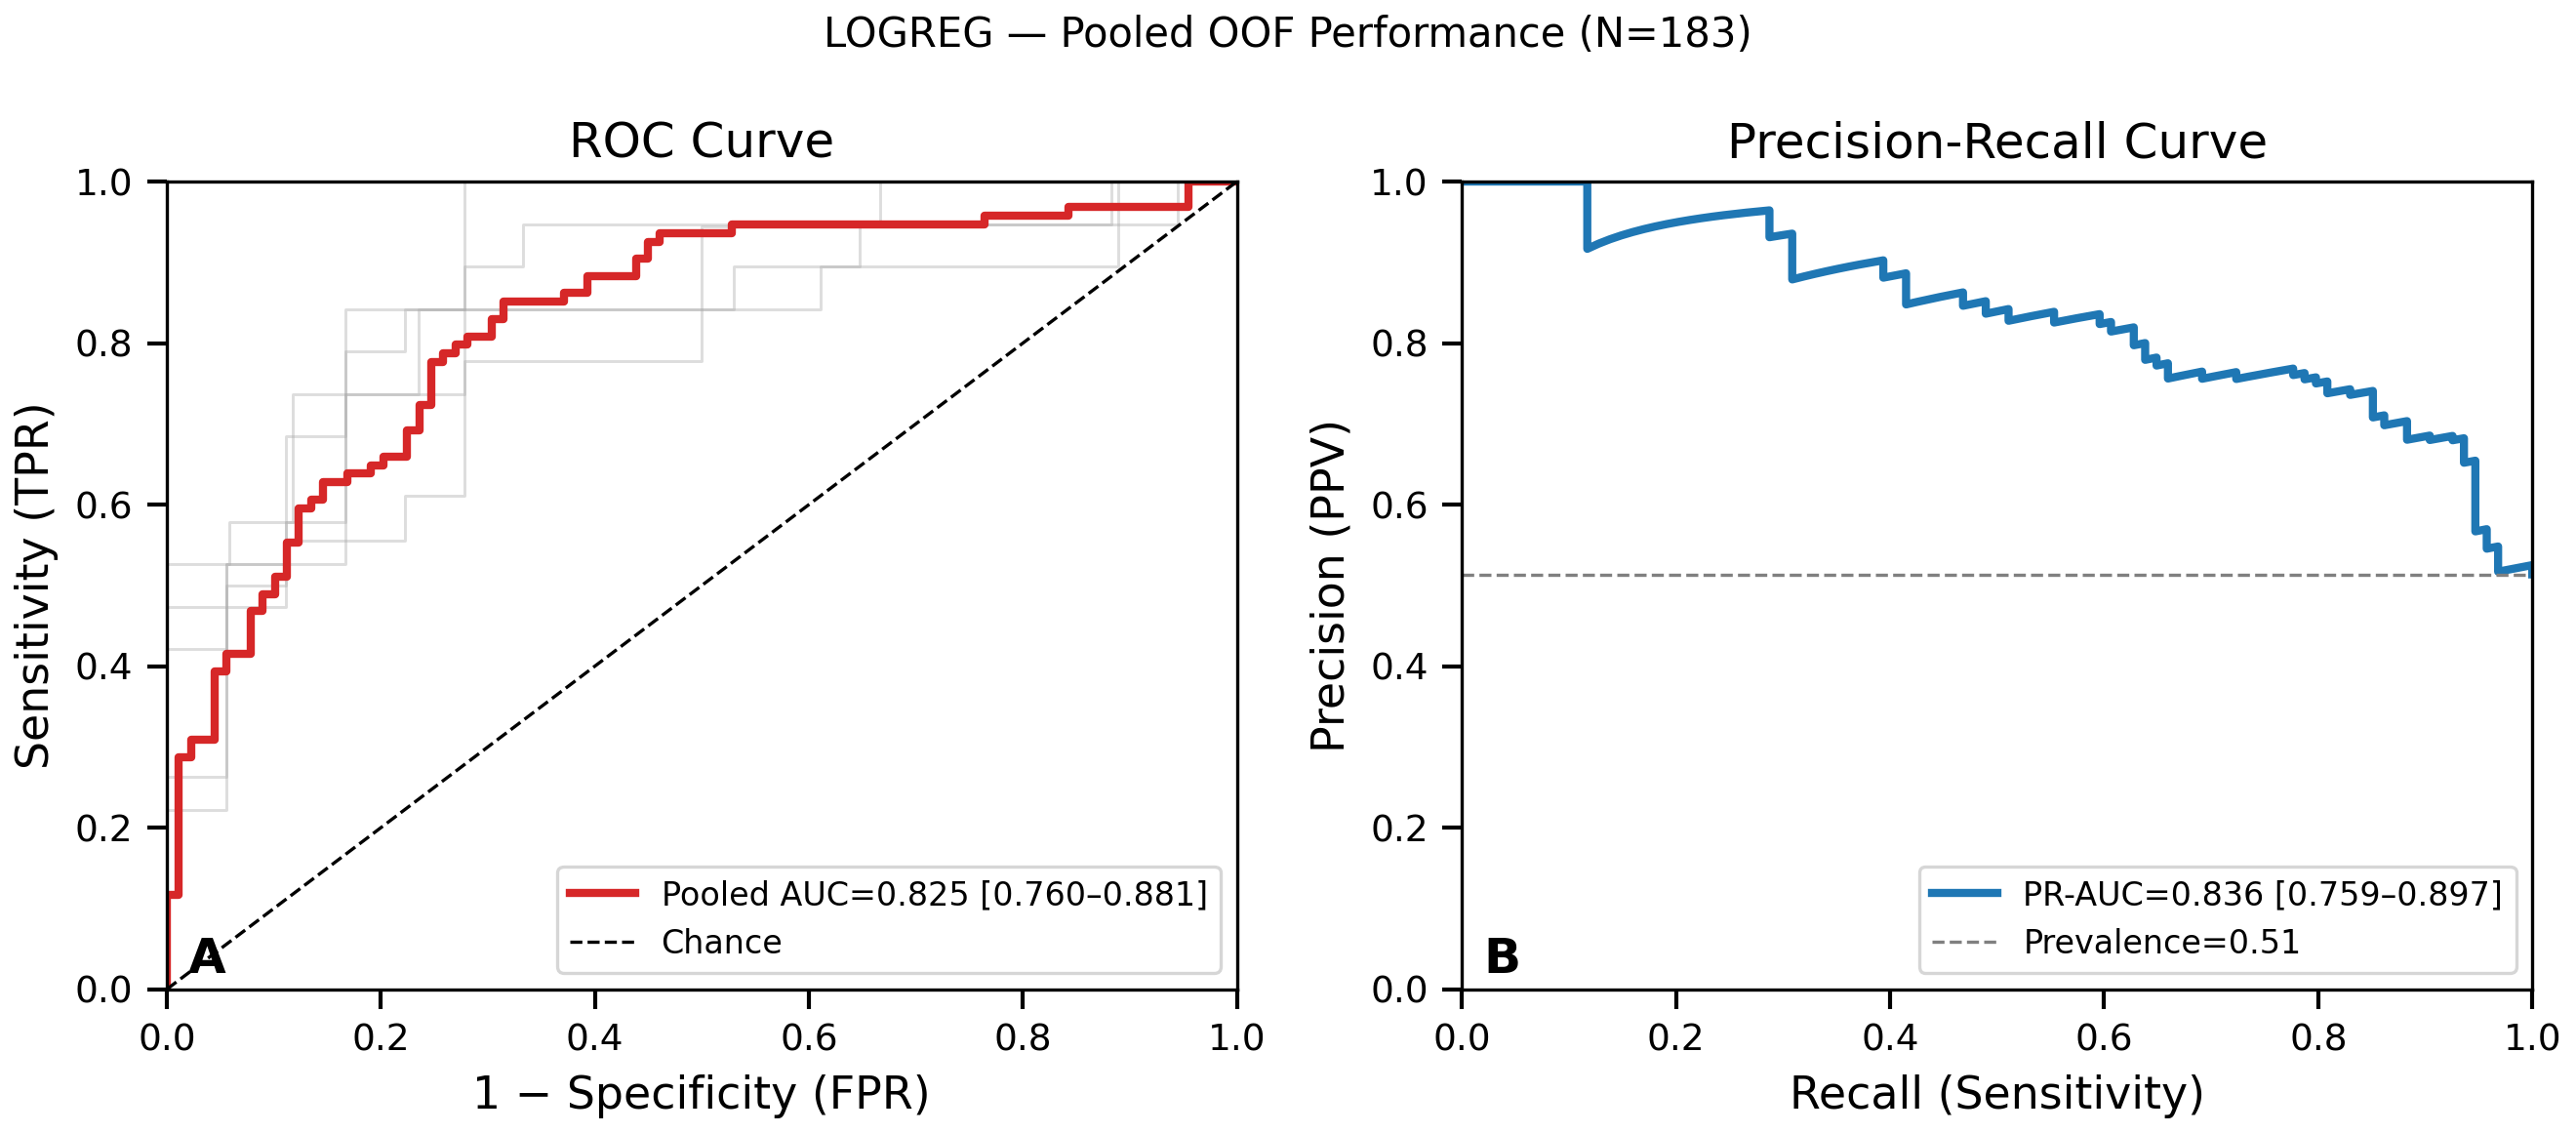

Saved: /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro/training_qc_paper_output/fig_roc_pr_logreg_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.png
Saved: /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro/training_qc_paper_output/fig_roc_pr_logreg_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.pdf
[OK] ROC/PR figure saved.
[OK] Performance table saved.


In [11]:
# ── 7a. ROC & PR curves (pooled OOF) ────────────────────────────────────────
fpr_p, tpr_p, _ = roc_curve(y_true_pooled, y_score_pooled)
prec_p, rec_p, _ = precision_recall_curve(y_true_pooled, y_score_pooled)

# Bootstrap CIs
auc_obs, auc_lo, auc_hi = bootstrap_auc_ci(y_true_pooled, y_score_pooled,
                                             n_boot=N_BOOT, seed=BOOT_SEED)
prauc_obs, prauc_lo, prauc_hi = bootstrap_prauc_ci(y_true_pooled, y_score_pooled,
                                                    n_boot=N_BOOT, seed=BOOT_SEED)
prev = float((y_true_pooled == 1).mean())

print(f"Pooled OOF  (N={len(y_true_pooled)}, prev={prev:.2f})")
print(f"  ROC-AUC  = {auc_obs:.4f}  95% CI [{auc_lo:.4f}, {auc_hi:.4f}]")
print(f"  PR-AUC   = {prauc_obs:.4f}  95% CI [{prauc_lo:.4f}, {prauc_hi:.4f}]")

# ── 7b. Per-fold AUC lines ───────────────────────────────────────────────────
fold_rocs = []
for fold_k, grp in preds_df.groupby("fold"):
    yt = grp["y_true"].values.astype(int)
    ys = grp["y_score_final"].values.astype(float)
    if len(np.unique(yt)) < 2:
        continue
    fp_k, tp_k, _ = roc_curve(yt, ys)
    fold_rocs.append((fold_k, fp_k, tp_k, float(roc_auc_score(yt, ys))))

# ── 7c. Figure: ROC + PR ─────────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# ROC
for fold_k, fp_k, tp_k, auc_k in fold_rocs:
    ax1.plot(fp_k, tp_k, lw=0.7, alpha=0.4, color="#aaaaaa")
ax1.plot(fpr_p, tpr_p, lw=2, color="#d62728",
         label=f"Pooled AUC={auc_obs:.3f} [{auc_lo:.3f}–{auc_hi:.3f}]")
ax1.plot([0,1],[0,1], "k--", lw=0.8, label="Chance")
ax1.set_xlabel("1 − Specificity (FPR)")
ax1.set_ylabel("Sensitivity (TPR)")
ax1.set_title("ROC Curve")
ax1.legend(fontsize=8)
ax1.set_xlim(0,1); ax1.set_ylim(0,1)
ax1.text(0.02, 0.02, "A", fontsize=12, fontweight="bold", transform=ax1.transAxes)

# PR
ax2.plot(rec_p, prec_p, lw=2, color="#1f77b4",
         label=f"PR-AUC={prauc_obs:.3f} [{prauc_lo:.3f}–{prauc_hi:.3f}]")
ax2.axhline(prev, color="gray", lw=0.8, linestyle="--", label=f"Prevalence={prev:.2f}")
ax2.set_xlabel("Recall (Sensitivity)")
ax2.set_ylabel("Precision (PPV)")
ax2.set_title("Precision-Recall Curve")
ax2.legend(fontsize=8)
ax2.set_xlim(0,1); ax2.set_ylim(0,1)
ax2.text(0.02, 0.02, "B", fontsize=12, fontweight="bold", transform=ax2.transAxes)

fig.suptitle(f"{TARGET_CLF.upper()} — Pooled OOF Performance (N={len(y_true_pooled)})", fontsize=10)
plt.tight_layout()
show_fig(fig)

save_figure(fig, OUTPUT_DIR / f"fig_roc_pr_{TARGET_CLF}_{RUN_TAG}", formats=FIG_FORMATS)
print(f"[OK] ROC/PR figure saved.")

# Export performance table
perf_df = pd.DataFrame([{
    "classifier": TARGET_CLF,
    "N_pooled": len(y_true_pooled),
    "prevalence": round(prev, 4),
    "AUC": round(auc_obs, 4), "AUC_lo95": round(auc_lo, 4), "AUC_hi95": round(auc_hi, 4),
    "PR_AUC": round(prauc_obs, 4), "PR_AUC_lo95": round(prauc_lo, 4), "PR_AUC_hi95": round(prauc_hi, 4),
}])
perf_df.to_csv(OUTPUT_DIR / f"table_performance_{TARGET_CLF}.csv", index=False)
print(f"[OK] Performance table saved.")


## §8 — Operating Points (Unbiased OOF Threshold Transfer)

Thresholds are estimated on the *training* folds for each outer fold and
applied to the held-out test fold — avoiding the optimism of choosing the
threshold on test data.  Three strategies:

- **Youden** (Sensitivity + Specificity − 1 maximised)
- **Screening** (Sensitivity ≥ TARGET_SENS)
- **Cost** (minimise C_FN × FN + C_FP × FP)


In [12]:
TARGET_SENS = 0.85
C_FN = 3.0
C_FP = 1.0


def _threshold_from_train(y_train, s_train, mode="youden", target_sens=0.85, c_fn=3.0, c_fp=1.0):
    y_train = np.asarray(y_train, dtype=int)
    s_train = np.asarray(s_train, dtype=float)
    fpr, tpr, thr = roc_curve(y_train, s_train)
    finite = np.isfinite(thr)
    fpr, tpr, thr = fpr[finite], tpr[finite], thr[finite]
    if len(thr) == 0:
        return np.nanmedian(s_train)
    if mode == "youden":
        idx = np.argmax(tpr - fpr)
    elif mode == "screening":
        cands = np.where(tpr >= target_sens)[0]
        idx = int(cands[-1]) if len(cands) else int(np.argmax(tpr))
    elif mode == "cost":
        fn_rate = 1 - tpr
        cost = c_fn * fn_rate + c_fp * fpr
        idx = int(np.argmin(cost))
    else:
        idx = int(np.argmax(tpr - fpr))
    return float(thr[idx])


def _confusion_stats(y_true, y_score, thr):
    y_pred = (np.asarray(y_score, dtype=float) >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(np.asarray(y_true, dtype=int),
                                       y_pred, labels=[0,1]).ravel()
    sens = tp / (tp+fn) if (tp+fn) > 0 else np.nan
    spec = tn / (tn+fp) if (tn+fp) > 0 else np.nan
    ppv  = tp / (tp+fp) if (tp+fp) > 0 else np.nan
    npv  = tn / (tn+fn) if (tn+fn) > 0 else np.nan
    return dict(tn=int(tn), fp=int(fp), fn=int(fn), tp=int(tp),
                sens=sens, spec=spec, ppv=ppv, npv=npv)


modes = ["youden", "screening", "cost"]
oof_rows = []
oof_preds_with_thr = []

for mode in modes:
    thresholds, test_stats = [], []
    for fold_k, test_grp in preds_df.groupby("fold"):
        train_grp = preds_df[preds_df["fold"] != fold_k]
        if len(train_grp) == 0 or len(np.unique(train_grp["y_true"])) < 2:
            continue
        thr_k = _threshold_from_train(
            train_grp["y_true"], train_grp["y_score_final"],
            mode=mode, target_sens=TARGET_SENS, c_fn=C_FN, c_fp=C_FP
        )
        thresholds.append(thr_k)
        stats_k = _confusion_stats(test_grp["y_true"], test_grp["y_score_final"], thr_k)
        test_stats.append(stats_k)

    if not thresholds:
        continue
    stats_arr = {k: np.array([s[k] for s in test_stats]) for k in ["tn","fp","fn","tp",
                                                                      "sens","spec","ppv","npv"]}
    pooled_cm = {k: int(stats_arr[k].sum()) for k in ["tn","fp","fn","tp"]}
    p_tn,p_fp,p_fn,p_tp = pooled_cm["tn"],pooled_cm["fp"],pooled_cm["fn"],pooled_cm["tp"]
    oof_rows.append({
        "mode": mode,
        "threshold_mean": round(float(np.mean(thresholds)), 4),
        "threshold_sd":   round(float(np.std(thresholds)),  4),
        "sens_oof":  round(p_tp/(p_tp+p_fn) if (p_tp+p_fn) else np.nan, 4),
        "spec_oof":  round(p_tn/(p_tn+p_fp) if (p_tn+p_fp) else np.nan, 4),
        "ppv_oof":   round(p_tp/(p_tp+p_fp) if (p_tp+p_fp) else np.nan, 4),
        "npv_oof":   round(p_tn/(p_tn+p_fn) if (p_tn+p_fn) else np.nan, 4),
        **pooled_cm,
    })

oof_table = pd.DataFrame(oof_rows)
print("=== OOF Operating Points ===")
print(oof_table.to_string(index=False))
oof_table.to_csv(OUTPUT_DIR / f"table_operating_points_oof_{TARGET_CLF}.csv", index=False)
with open(OUTPUT_DIR / f"table_operating_points_oof_{TARGET_CLF}.tex", "w") as f:
    f.write(oof_table.to_latex(index=False, escape=False, float_format="%.4f",
            caption="OOF operating points (unbiased threshold transfer).",
            label=f"tab:oof_ops_{TARGET_CLF}"))
print(f"[OK] OOF table saved.")


=== OOF Operating Points ===
     mode  threshold_mean  threshold_sd  sens_oof  spec_oof  ppv_oof  npv_oof  tn  fp  fn  tp
   youden          0.5237        0.0159    0.7660    0.7079   0.7347   0.7412  63  26  22  72
screening          0.0867        0.0133    1.0000    0.0225   0.5193   1.0000   2  87   0  94
     cost          0.4125        0.0006    0.9255    0.5393   0.6797   0.8727  48  41   7  87
[OK] OOF table saved.


## §9 — Calibration Analysis

=== Pooled Calibration ===
  N                     : 183
  n_pos                 : 94
  n_neg                 : 89
  prev                  : 0.5137
  Brier                 : 0.1799
  BSS                   : 0.6498
  ECE_w                 : 0.1023
  MCE                   : 0.2582
  calib_intercept       : -0.0943
  calib_slope           : 1.5781


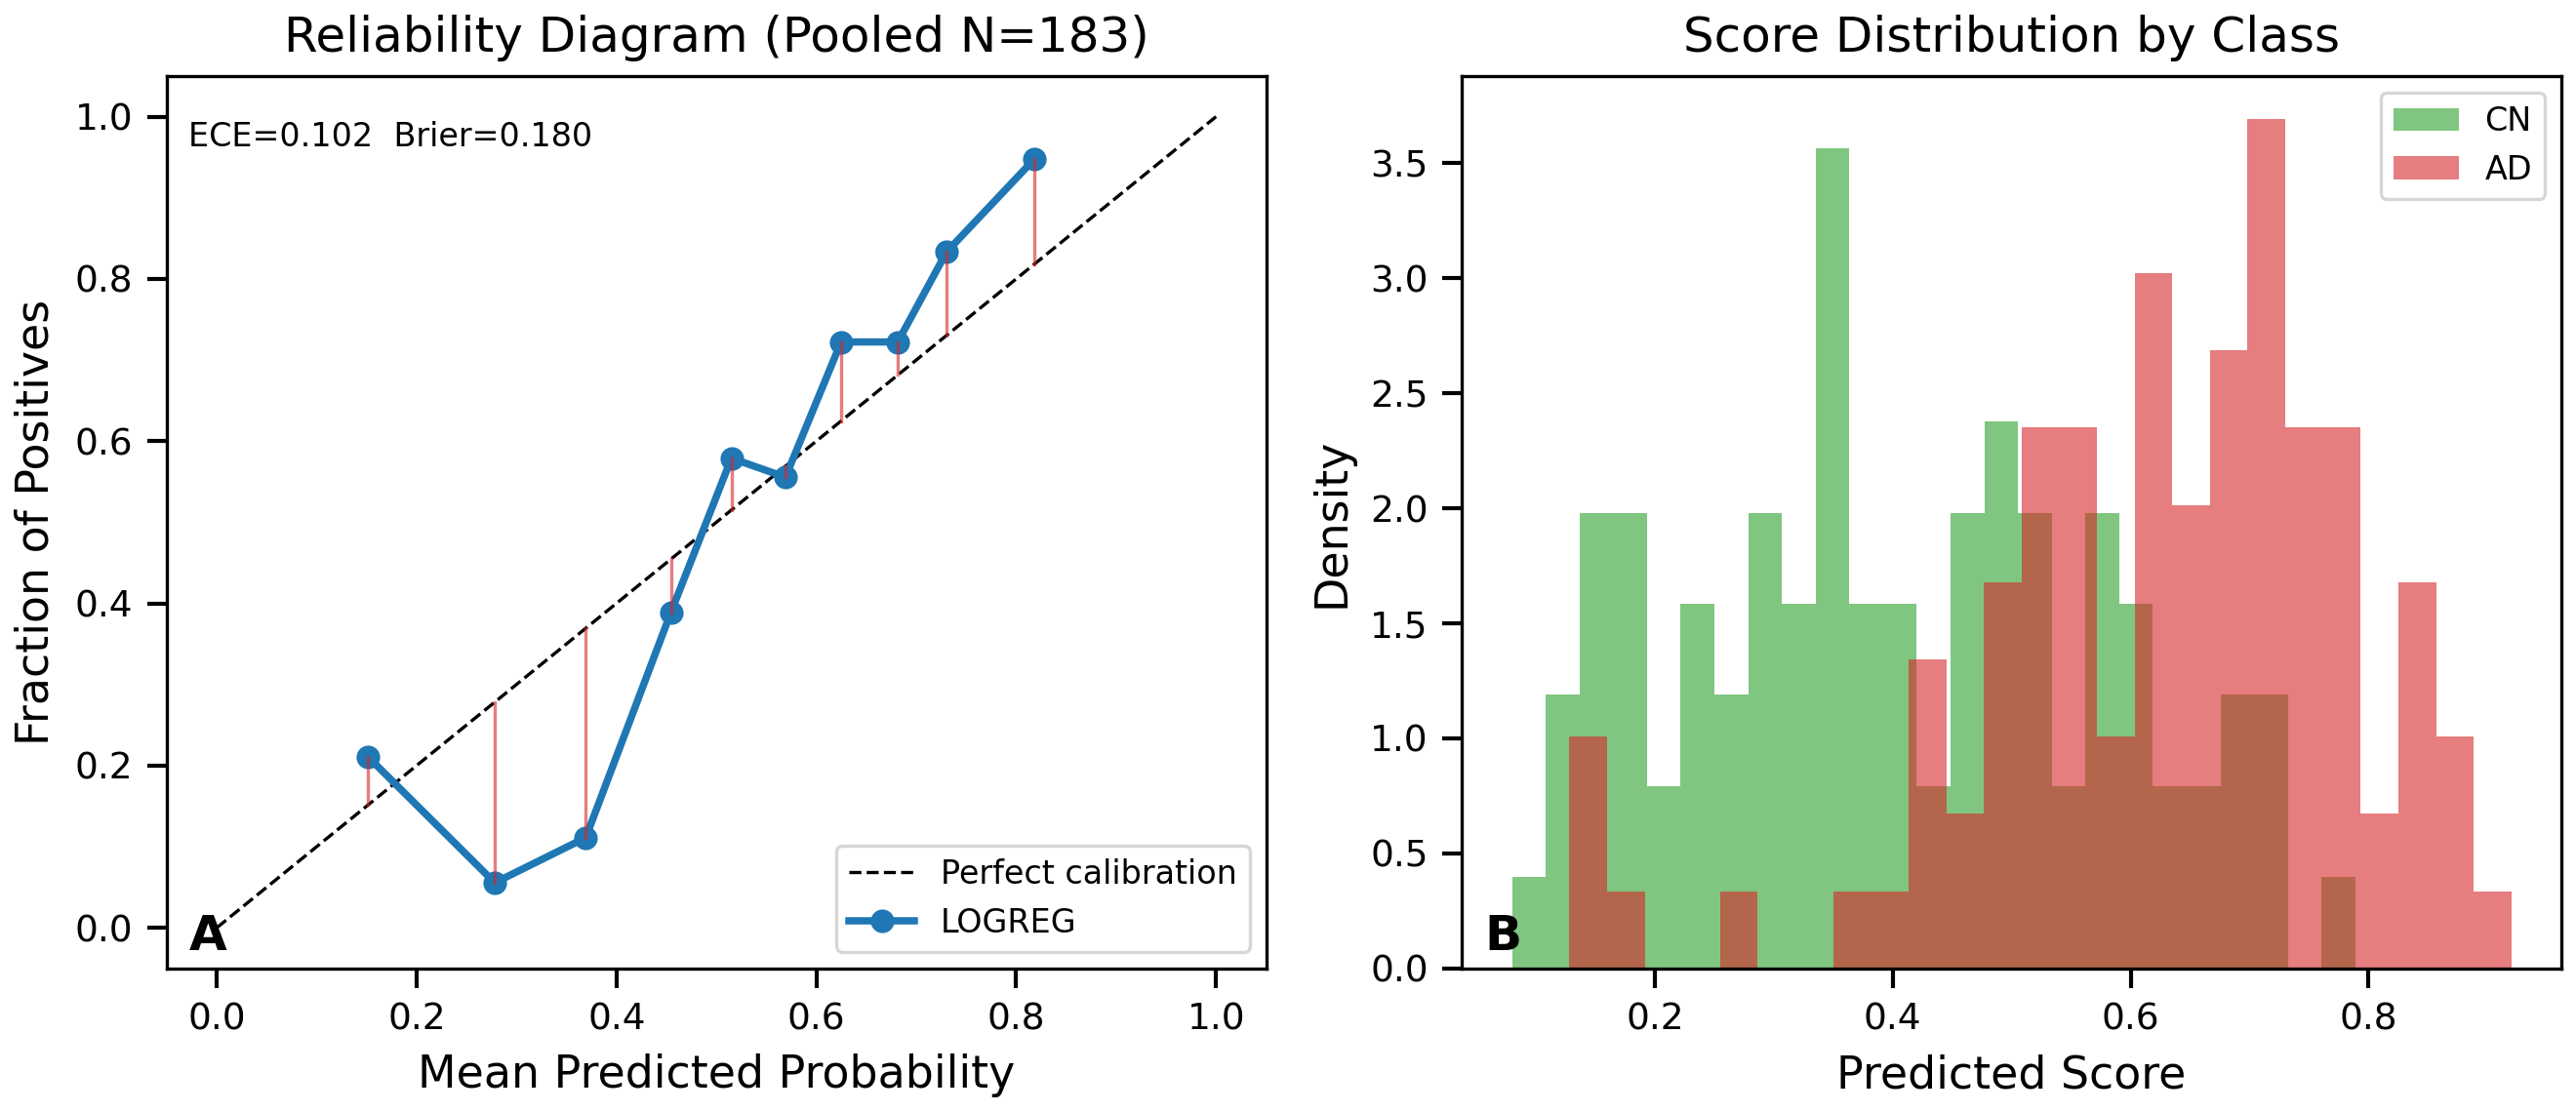

Saved: /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro/training_qc_paper_output/fig_calibration_logreg_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.png
Saved: /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro/training_qc_paper_output/fig_calibration_logreg_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.pdf
[OK] Calibration figure saved.


In [13]:
# ── 9a. Pooled calibration ───────────────────────────────────────────────────
calib_metrics, calib_bins = reliability_report(
    preds_df.rename(columns={"y_true": "_y", "y_score_final": "_p"}),
    y="_y", p="_p", n_bins=10, strategy="quantile"
)

print("=== Pooled Calibration ===")
for k, v in calib_metrics.items():
    print(f"  {k:<22}: {v:.4f}" if isinstance(v, float) else f"  {k:<22}: {v}")

# Calibration curve
prob_true, prob_pred = calibration_curve(y_true_pooled, y_score_pooled,
                                          n_bins=10, strategy="quantile")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# Reliability diagram
ax1.plot([0,1],[0,1], "k--", lw=0.8, label="Perfect calibration")
ax1.plot(prob_pred, prob_true, "o-", lw=1.8, color="#1f77b4", label=f"{TARGET_CLF.upper()}")
# Shade gap
for xp, yt in zip(prob_pred, prob_true):
    ax1.plot([xp, xp], [xp, yt], "-", color="#d62728", lw=0.8, alpha=0.6)
ax1.set_xlabel("Mean Predicted Probability")
ax1.set_ylabel("Fraction of Positives")
ax1.set_title(f"Reliability Diagram (Pooled N={calib_metrics['N']})")
ax1.legend(fontsize=8)
ax1.text(0.02, 0.95, f"ECE={calib_metrics['ECE_w']:.3f}  Brier={calib_metrics['Brier']:.3f}",
         transform=ax1.transAxes, fontsize=8, va="top")
ax1.text(0.02, 0.02, "A", fontsize=12, fontweight="bold", transform=ax1.transAxes)

# Score distribution
ax2.hist(preds_df.loc[preds_df["y_true"]==0,"y_score_final"], bins=25,
         alpha=0.6, color="#2ca02c", label="CN", density=True)
ax2.hist(preds_df.loc[preds_df["y_true"]==1,"y_score_final"], bins=25,
         alpha=0.6, color="#d62728", label="AD", density=True)
ax2.set_xlabel("Predicted Score")
ax2.set_ylabel("Density")
ax2.set_title("Score Distribution by Class")
ax2.legend(fontsize=8)
ax2.text(0.02, 0.02, "B", fontsize=12, fontweight="bold", transform=ax2.transAxes)

plt.tight_layout()
show_fig(fig)
save_figure(fig, OUTPUT_DIR / f"fig_calibration_{TARGET_CLF}_{RUN_TAG}", formats=FIG_FORMATS)

print(f"[OK] Calibration figure saved.")

# Export
calib_df = pd.DataFrame([calib_metrics])
calib_df.to_csv(OUTPUT_DIR / f"table_calibration_{TARGET_CLF}.csv", index=False)


### §9b — Calibration per Confounder

In [14]:
# ── 9b. Calibration per confounder (Manufacturer/Vendor) ────────────────────
if _meta is None:
    print("[SKIP] No metadata available from §4b. Set METADATA_PATH in §1.")
else:
    conf_col = CONFOUNDER_COL if CONFOUNDER_COL is not None else detect_confounder_column(_meta)
    print(f"[OK] confounder column: {conf_col}")

    # Merge with predictions via SubjectID
    id_col = ID_COL if ID_COL is not None else next((c for c in ["SubjectID","RID","participant_id","ID"] if c in _meta.columns), None)
    if id_col and conf_col and "SubjectID" in preds_df.columns:
        merged = preds_df.merge(
            _meta[[id_col, conf_col]].rename(columns={id_col:"SubjectID"}),
            on="SubjectID", how="left"
        )
        merged["_confounder"] = merged[conf_col].fillna("Unknown").astype(str)

        # Domain support report (before per-domain calibration)
        support_df = domain_support_report(
            merged.rename(columns={"y_true":"_y"}),
            dom_col="_confounder", y_col="_y"
        )
        print("\n=== Domain Support ===")
        print(support_df.to_string(index=False))
        support_df.to_csv(OUTPUT_DIR / f"table_domain_support_{TARGET_CLF}.csv", index=False)

        # Per-domain calibration
        calib_rows = []
        for dom, grp in merged.groupby("_confounder"):
            if len(grp) < 10 or grp["y_true"].nunique() < 2:
                calib_rows.append({"domain": dom, "N": len(grp),
                                   "note": "insufficient_data (n<10 or single class)",
                                   "Brier": np.nan, "ECE_w": np.nan,
                                   "calib_slope": np.nan, "calib_intercept": np.nan})
                continue
            try:
                m, _ = reliability_report(
                    grp.rename(columns={"y_true":"_y","y_score_final":"_p"}),
                    y="_y", p="_p"
                )
                m["domain"] = dom
                m["note"] = "ok"
                calib_rows.append(m)
            except Exception as e:
                calib_rows.append({"domain":dom,"N":len(grp),"note":str(e),
                                   "Brier":np.nan,"ECE_w":np.nan,
                                   "calib_slope":np.nan,"calib_intercept":np.nan})

        calib_dom_df = pd.DataFrame(calib_rows)
        _note_col = calib_dom_df.pop("note")
        calib_dom_df["note"] = _note_col
        print("\n=== Calibration per Domain ===")
        _show_cols = [c for c in ["domain","N","Brier","ECE_w","calib_slope","calib_intercept","note"]
                      if c in calib_dom_df.columns]
        print(calib_dom_df[_show_cols].to_string(index=False))
        calib_dom_df.to_csv(OUTPUT_DIR / f"table_calibration_per_domain_{TARGET_CLF}.csv", index=False)
        print(f"[OK] Per-domain calibration table saved.")
    else:
        print(f"[SKIP] Cannot merge — id_col={id_col}, conf_col={conf_col}, "
              f"SubjectID in preds={('SubjectID' in preds_df.columns)}")

[OK] confounder column: Manufacturer

=== Domain Support ===
            domain   n  n_classes  n_pos  n_neg  valid
           Philips 135          2     46     89   True
           SIEMENS  27          1     27      0  False
GE MEDICAL SYSTEMS  21          1     21      0  False

=== Calibration per Domain ===
            domain   N    Brier    ECE_w  calib_slope  calib_intercept                                     note
GE MEDICAL SYSTEMS  21      NaN      NaN          NaN              NaN insufficient_data (n<10 or single class)
           Philips 135 0.210956 0.143823     0.949449        -0.526369                                       ok
           SIEMENS  27      NaN      NaN          NaN              NaN insufficient_data (n<10 or single class)
[OK] Per-domain calibration table saved.


## §10 — Scanner Leakage / Confounder Analysis

We test whether the VAE's latent space leaks manufacturer identity
(Siemens / GE / Philips) using a logistic-regression classifier on the
latent μ.  A balanced accuracy near chance (1/n_manufacturers) is desirable.

Sign-flip permutation test per fold: H₀: mean(Δacc_raw − Δacc_latent) = 0.


In [15]:
if _meta is not None and "SubjectID" in preds_df.columns:
    conf = detect_confounder_column(_meta)
    idc  = next((c for c in ["SubjectID","RID","participant_id","ID"] if c in _meta.columns), None)
    if conf and idc:
        tmp = preds_df.merge(_meta[[idc, conf]].rename(columns={idc:"SubjectID"}), on="SubjectID", how="left")
        print(tmp.groupby(["fold", conf]).size().unstack(fill_value=0))


Manufacturer  GE MEDICAL SYSTEMS  Philips  SIEMENS
fold                                              
1                              1       30        6
2                              7       29        1
3                              3       25        9
4                              4       25        7
5                              6       26        4


In [16]:
# --- Diagnóstico de soporte por fold para leakage ---
tmp = preds_df.merge(
    _meta[[idc, conf]].rename(columns={idc:"SubjectID"}),
    on="SubjectID", how="left"
)

support = (tmp.groupby(["fold", conf]).size()
             .unstack(fill_value=0)
             .assign(
                 n_classes=lambda d: (d > 0).sum(axis=1),
                 min_count=lambda d: d.replace(0, np.nan).min(axis=1),
             )
          )
display(support)

# Si tu evaluate_scanner_leakage usa n_splits fijo (ej 3):
N_SPLITS_DEFAULT = 3
support["feasible_for_cv"] = support["min_count"] >= N_SPLITS_DEFAULT
display(support[["n_classes","min_count","feasible_for_cv"]])


Manufacturer,GE MEDICAL SYSTEMS,Philips,SIEMENS,n_classes,min_count
fold,,,,,
1,1,30,6,3,1
2,7,29,1,3,1
3,3,25,9,3,3
4,4,25,7,3,3
5,6,26,4,3,3


Manufacturer,n_classes,min_count,feasible_for_cv
fold,,,
1,3,1,False
2,3,1,False
3,3,3,True
4,3,3,True
5,3,3,True


=== Latent QC Metrics (per fold) ===
 fold  silhouette_latent  acc_site_latent  acc_site_raw  n_sites  chance_level
    1             0.0296              NaN           NaN      NaN           NaN
    2             0.0166              NaN           NaN      NaN           NaN
    3             0.0245           0.5556        0.5417      3.0        0.3333
    4             0.0098           0.4901        0.5278      3.0        0.3333
    5             0.0120           0.5575        0.5417      3.0        0.3333

=== Sign-flip permutation test (acc_raw - acc_latent) ===
  N folds with data : 3
  Observed mean Δ   : 0.0026
  p (one-sided >0)  : 0.5000
  p (two-sided)     : 1.0000


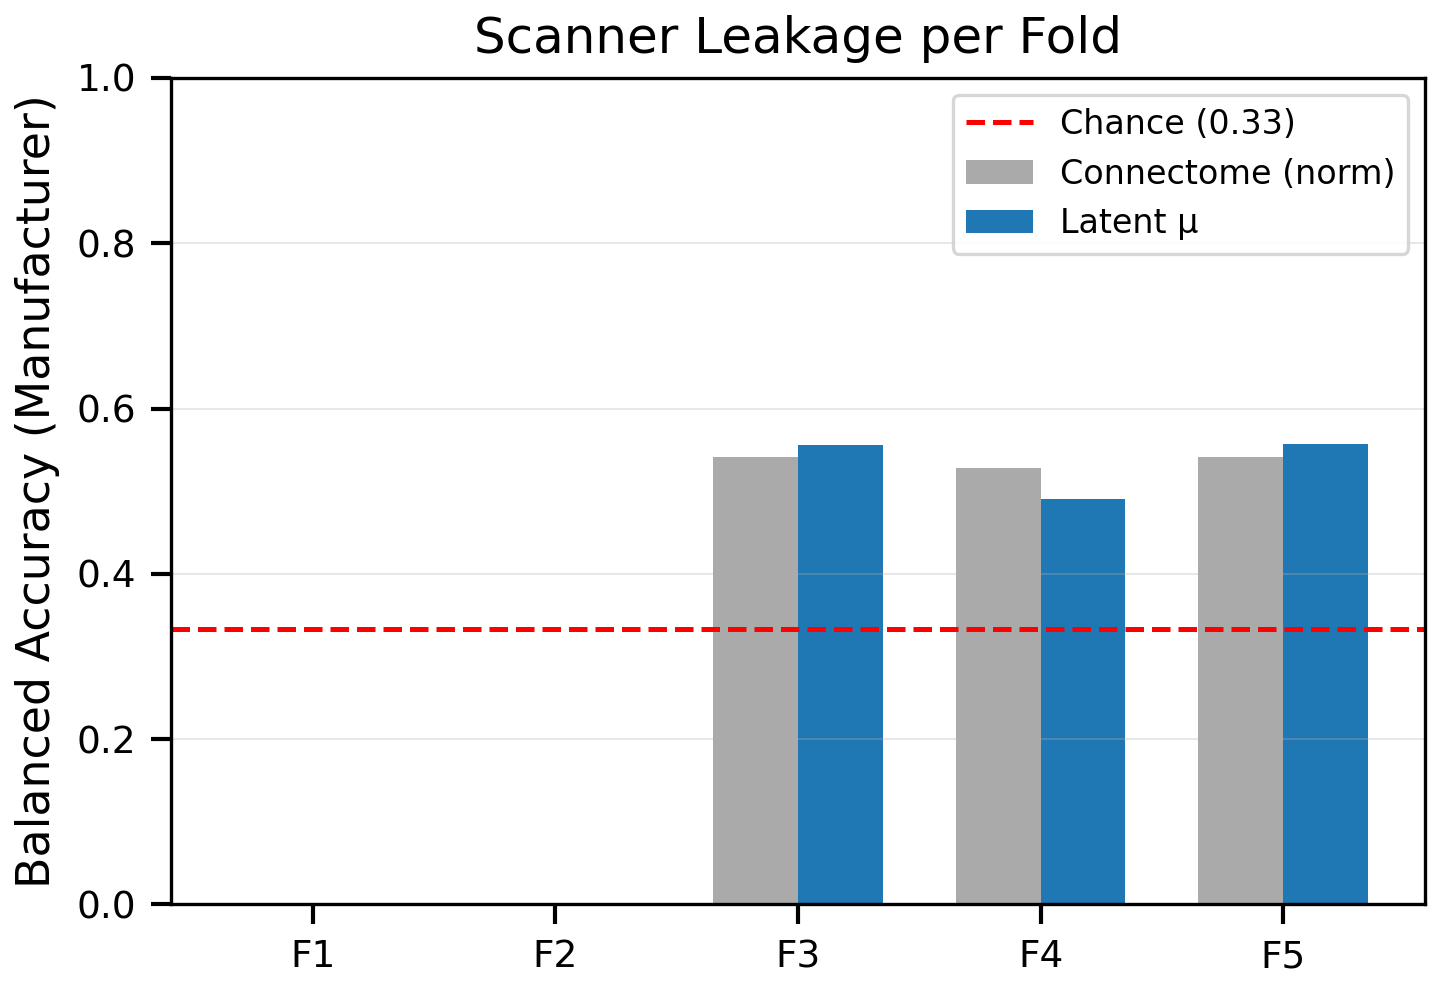

Saved: /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro/training_qc_paper_output/fig_scanner_leakage_logreg_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.png
Saved: /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro/training_qc_paper_output/fig_scanner_leakage_logreg_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.pdf
[OK] Scanner leakage figure saved.


In [17]:
if qc_latent is None:
    print("[SKIP] No latent_qc_metrics.csv found per fold.")
else:
    print("=== Latent QC Metrics (per fold) ===")
    _qc_cols = [c for c in ["fold","silhouette_latent","acc_site_latent",
                             "acc_site_raw","n_sites","chance_level"]
                if c in qc_latent.columns]
    print(qc_latent[_qc_cols].round(4).to_string(index=False))

    # Sign-flip test: raw vs latent leakage reduction
    if "acc_site_raw" in qc_latent.columns and "acc_site_latent" in qc_latent.columns:
        delta = (qc_latent["acc_site_raw"] - qc_latent["acc_site_latent"]).dropna().values
        if len(delta) > 0:
            perm_result = exact_sign_permutation_test(delta)
            print(f"\n=== Sign-flip permutation test (acc_raw - acc_latent) ===")
            print(f"  N folds with data : {perm_result['n']}")
            print(f"  Observed mean Δ   : {perm_result['obs_mean']:.4f}")
            print(f"  p (one-sided >0)  : {perm_result['p_one_sided']:.4f}")
            print(f"  p (two-sided)     : {perm_result['p_two_sided']:.4f}")
        else:
            print("[WARN] No valid delta values for sign-flip test.")

    # Figure: leakage per fold
    if "acc_site_latent" in qc_latent.columns and qc_latent["acc_site_latent"].notna().any():
        fig, ax = plt.subplots(figsize=(5, 3.5))
        x = np.arange(len(qc_latent))
        w = 0.35
        ax.bar(x - w/2, qc_latent["acc_site_raw"].fillna(0), w,
               color="#aaaaaa", label="Connectome (norm)")
        ax.bar(x + w/2, qc_latent["acc_site_latent"].fillna(0), w,
               color="#1f77b4", label="Latent μ")
        if "chance_level" in qc_latent.columns:
            chance = qc_latent["chance_level"].mean()
            if np.isfinite(chance):
                ax.axhline(chance, color="red", lw=1.2, linestyle="--",
                           label=f"Chance ({chance:.2f})")
        ax.set_xticks(x)
        ax.set_xticklabels([f"F{k}" for k in qc_latent.get("fold", range(1, len(qc_latent)+1))],
                           fontsize=9)
        ax.set_ylabel("Balanced Accuracy (Manufacturer)")
        ax.set_title("Scanner Leakage per Fold")
        ax.legend(fontsize=8)
        ax.set_ylim(0, 1)
        ax.grid(True, axis="y", alpha=0.3)
        plt.tight_layout()
        show_fig(fig)
       
        save_figure(fig, OUTPUT_DIR / f"fig_scanner_leakage_{TARGET_CLF}_{RUN_TAG}",
                    formats=FIG_FORMATS)
        print(f"[OK] Scanner leakage figure saved.")


## §11 — VAE Training Dynamics

Best fold:  1 (AUC=0.8860)
Worst fold: 4 (AUC=0.7994)


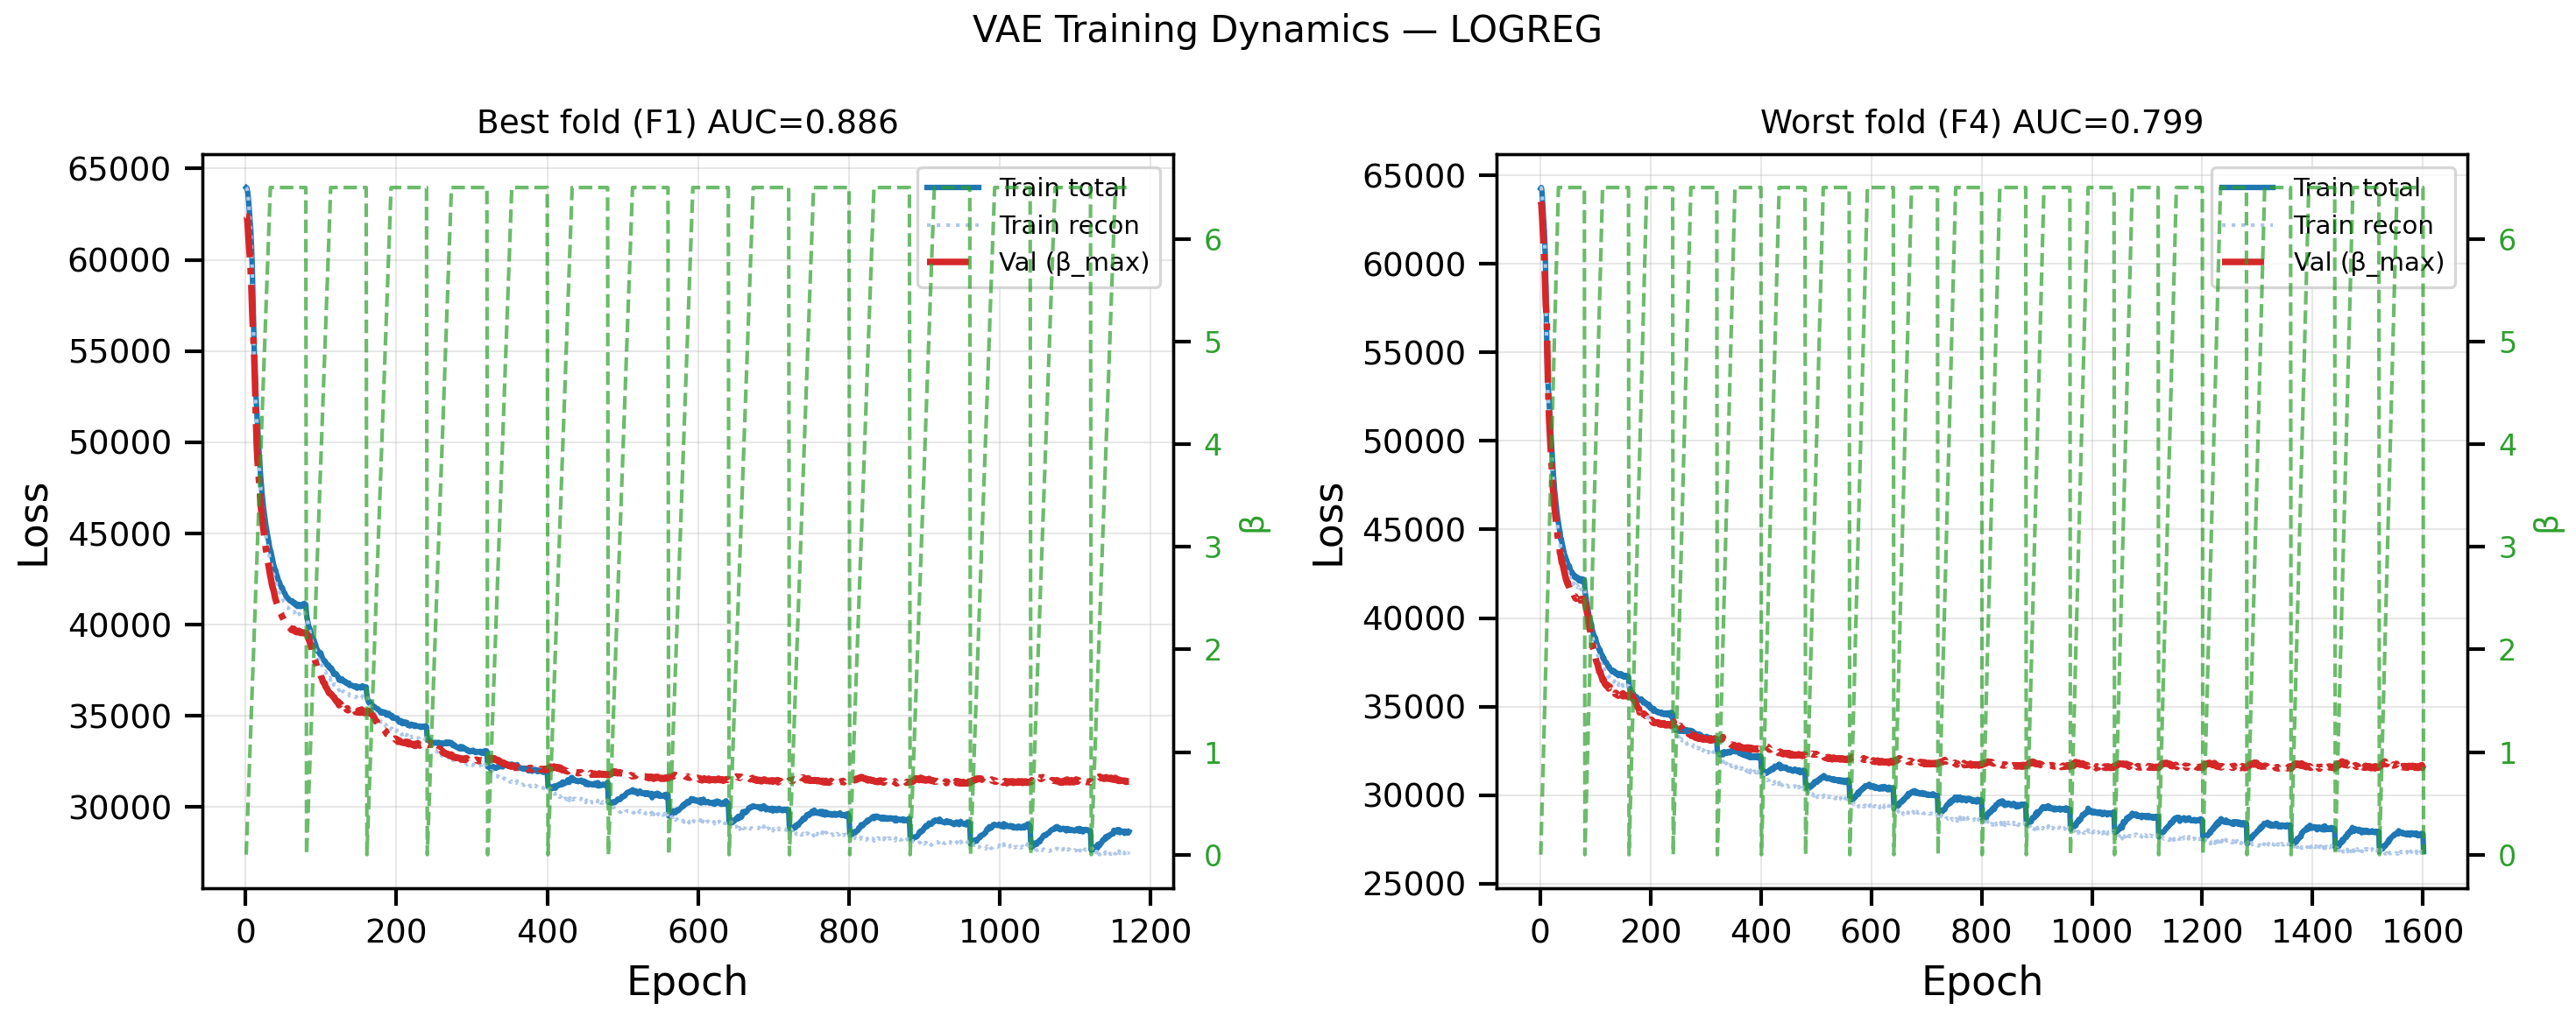

Saved: /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro/training_qc_paper_output/fig_vae_dynamics_logreg_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.png
Saved: /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro/training_qc_paper_output/fig_vae_dynamics_logreg_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.pdf
[OK] VAE training dynamics figure saved.


In [18]:
if vae_histories is None:
    print("[SKIP] No VAE training histories loaded. "
          "Re-run pipeline with --save_vae_training_history.")
elif "auc_final" not in df_summary.columns and "auc" not in df_summary.columns:
    print("[SKIP] No AUC column in df_summary to identify best/worst fold.")
else:
    _auc_col = "auc_final" if "auc_final" in df_summary.columns else "auc"
    _s = df_summary.dropna(subset=[_auc_col])
    if _s.empty:
        print("[SKIP] All AUC values are NaN.")
    else:
        best_fold  = int(_s.loc[_s[_auc_col].idxmax(), "fold"])
        worst_fold = int(_s.loc[_s[_auc_col].idxmin(), "fold"])
        print(f"Best fold:  {best_fold} (AUC={_s.loc[_s['fold']==best_fold, _auc_col].values[0]:.4f})")
        print(f"Worst fold: {worst_fold} (AUC={_s.loc[_s['fold']==worst_fold, _auc_col].values[0]:.4f})")

        folds_plot = [best_fold, worst_fold]
        labels_plot = ["Best", "Worst"]

        fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

        for ax, fold_k, label in zip(axes, folds_plot, labels_plot):
            hist = vae_histories[fold_k - 1]
            epochs = np.arange(1, len(hist["train_loss"]) + 1)

            ax.plot(epochs, hist["train_loss"],  lw=1.5, color="#1f77b4", label="Train total")
            ax.plot(epochs, hist["train_recon"], lw=1.0, color="#aec7e8", linestyle=":", label="Train recon")

            val_loss = hist.get("val_loss_modelsel", hist.get("val_loss", []))
            if any(v is not None and not (isinstance(v, float) and np.isnan(v)) for v in val_loss):
                ax.plot(epochs, val_loss, lw=1.8, color="#d62728", linestyle="-.", label="Val (β_max)")

            ax2 = ax.twinx()
            ax2.plot(epochs, hist["beta"], lw=1.0, color="#2ca02c", linestyle="--", alpha=0.7)
            ax2.set_ylabel("β", color="#2ca02c", fontsize=9)
            ax2.tick_params(axis="y", labelcolor="#2ca02c", labelsize=8)

            auc_k = _s.loc[_s["fold"]==fold_k, _auc_col].values
            auc_str = f"AUC={auc_k[0]:.3f}" if len(auc_k) else ""
            ax.set_title(f"{label} fold (F{fold_k}) {auc_str}", fontsize=9)
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")
            ax.legend(fontsize=7, loc="upper right")
            ax.grid(True, alpha=0.3)

        fig.suptitle(f"VAE Training Dynamics — {TARGET_CLF.upper()}", fontsize=10)
        plt.tight_layout()
        show_fig(fig)
        
        save_figure(fig, OUTPUT_DIR / f"fig_vae_dynamics_{TARGET_CLF}_{RUN_TAG}", formats=FIG_FORMATS)
        print(f"[OK] VAE training dynamics figure saved.")


## §12 — Statistical Validation

Stratified permutation test for pooled AUC: labels are permuted *within*
each manufacturer group to preserve the confounder marginal distribution.
H₀: the model uses no information beyond the manufacturer identity.

**Note:** Set `N_PERM=0` in §1 to skip (slow for large datasets).


In [19]:
if N_PERM <= 0:
    print("[SKIP] N_PERM=0 — set N_PERM > 0 in §1 to run permutation test.")
elif _meta is None:
    print("[SKIP] No metadata loaded — cannot stratify permutation test by confounder.")
else:
    _conf_col_perm = detect_confounder_column(_meta)
    _id_col_perm   = next((c for c in ["SubjectID","RID","participant_id","ID"]
                           if c in _meta.columns), None)
    if _conf_col_perm is None or _id_col_perm is None:
        print("[SKIP] No confounder or ID column found in metadata.")
    elif "SubjectID" not in preds_df.columns:
        print("[SKIP] 'SubjectID' not in preds_df — cannot merge for permutation test.")
    else:
        perm_df = preds_df.merge(
            _meta[[_id_col_perm, _conf_col_perm]].rename(columns={_id_col_perm:"SubjectID"}),
            on="SubjectID", how="left"
        )
        perm_df["_confounder"] = perm_df[_conf_col_perm].fillna("Unknown").astype(str)
        perm_df = perm_df.dropna(subset=["y_true","y_score_final"])

        print(f"[INFO] Running stratified permutation test (N_PERM={N_PERM}, "
              f"confounder='{_conf_col_perm}', N={len(perm_df)}) ...")

        perm_result = stratified_permutation_auc(
            perm_df.rename(columns={"y_true":"_y","y_score_final":"_p"}),
            y="_y", p="_p", group="_confounder",
            n_perm=N_PERM, seed=PERM_SEED
        )

        print(f"\n=== Stratified Permutation Test (AUC) ===")
        print(f"  Observed AUC  : {perm_result['auc_obs']:.4f}")
        print(f"  Null mean±sd  : {perm_result['null_mean']:.4f} ± {perm_result['null_std']:.4f}")
        print(f"  p (one-sided) : {perm_result['p_one_sided']:.4f}")
        print(f"  p (two-sided) : {perm_result['p_two_sided']:.4f}")
        print(f"  N permutations: {perm_result['n_perm']}")

        # Export
        pd.DataFrame([{
            **perm_result,
            "confounder_col": _conf_col_perm,
            "classifier": TARGET_CLF,
            "run_tag": RUN_TAG,
        }]).to_csv(OUTPUT_DIR / f"table_permutation_test_{TARGET_CLF}.csv", index=False)
        print(f"[OK] Permutation test result saved.")


[INFO] Running stratified permutation test (N_PERM=2000, confounder='Manufacturer', N=183) ...

=== Stratified Permutation Test (AUC) ===
  Observed AUC  : 0.8249
  Null mean±sd  : 0.7034 ± 0.0307
  p (one-sided) : 0.0000
  p (two-sided) : 0.0000
  N permutations: 2000
[OK] Permutation test result saved.


## §13 — Information Theory & Latent QC

Mutual information between the confounder (manufacturer) and the predicted
score, compared to MI between the confounder and the true label.

> **Interpretation:** If MI(score, manufacturer) >> MI(score_null, manufacturer),
> the model may be encoding scanner effects in its predictions.


In [20]:
if _meta is None or "SubjectID" not in preds_df.columns:
    print("[SKIP] No metadata — skipping information theory analysis.")
else:
    _conf_col_it = detect_confounder_column(_meta)
    _id_col_it   = next((c for c in ["SubjectID","RID","participant_id","ID"]
                         if c in _meta.columns), None)

    if _conf_col_it is None or _id_col_it is None:
        print("[SKIP] No confounder or ID column found.")
    else:
        it_df = preds_df.merge(
            _meta[[_id_col_it, _conf_col_it]].rename(columns={_id_col_it:"SubjectID"}),
            on="SubjectID", how="left"
        ).dropna(subset=["y_true","y_score_final",_conf_col_it])

        y  = it_df["y_true"].values.astype(int)
        s  = it_df["_confounder" if "_confounder" in it_df.columns
                   else _conf_col_it].fillna("Unknown").astype(str).values

        # Binarise score at median for discrete MI approximation
        p_score = it_df["y_score_final"].values
        score_bin = (p_score >= np.median(p_score)).astype(int)

        h_y        = entropy_bits(y)
        h_s        = entropy_bits(s)
        mi_y_s     = mi_bits(y, s)
        mi_score_s = mi_bits(score_bin, s)
        mi_y_score = mi_bits(y, score_bin)
        crv        = cramers_v_bias_corrected(s, y)

        print("=== Information Theory Summary ===")
        print(f"  H(Y)              = {h_y:.4f} bits")
        print(f"  H(Confounder)     = {h_s:.4f} bits")
        print(f"  MI(Y, Confounder) = {mi_y_s:.4f} bits  (Cramér's V={crv:.3f})")
        print(f"  MI(Score_bin, Confounder) = {mi_score_s:.4f} bits")
        print(f"  MI(Y, Score_bin)          = {mi_y_score:.4f} bits")
        print(f"  NMI(Y, Confounder)        = {nmi(y, s):.4f}")

        it_summary = pd.DataFrame([{
            "H_Y": h_y, "H_confounder": h_s,
            "MI_Y_confounder": mi_y_s, "CramersV": crv,
            "MI_score_confounder": mi_score_s, "MI_Y_score": mi_y_score,
            "NMI_Y_confounder": nmi(y,s),
        }])
        it_summary.to_csv(OUTPUT_DIR / f"table_information_theory_{TARGET_CLF}.csv", index=False)
        print(f"[OK] Information theory table saved.")


=== Information Theory Summary ===
  H(Y)              = 0.9995 bits
  H(Confounder)     = 1.0895 bits
  MI(Y, Confounder) = 0.3167 bits  (Cramér's V=0.572)
  MI(Score_bin, Confounder) = 0.1991 bits
  MI(Y, Score_bin)          = 0.1866 bits
  NMI(Y, Confounder)        = 0.3169
[OK] Information theory table saved.


## §14 — Summary Tables (Publication-ready)

In [21]:
# ── Table 1: Per-classifier comparison (all classifiers) ──────────────────
# Aggregate all classifiers from metrics_df
clf_types = metrics_df["actual_classifier_type"].unique()
clf_name_map = {
    "logreg": "Logistic Regression", "svm": "SVM",
    "rf": "Random Forest", "gb": "Gradient Boosting",
    "mlp": "MLP", "nb": "Naive Bayes",
}

summary_rows = []
for clf in clf_types:
    sub = metrics_df[metrics_df["actual_classifier_type"] == clf]
    auc_col = "auc_final" if "auc_final" in sub.columns else "auc"
    pr_col  = "pr_auc_final" if "pr_auc_final" in sub.columns else "pr_auc"
    row = {"Classifier": clf_name_map.get(clf, clf.upper())}
    for col, label in [(auc_col, "AUC"), (pr_col, "PR-AUC"),
                       ("balanced_accuracy", "BAcc"), ("f1_score", "F1")]:
        if col in sub.columns and sub[col].notna().any():
            row[label]    = f"{sub[col].mean():.3f}"
            row[label+"_sd"] = f"{sub[col].std():.3f}"
    summary_rows.append(row)

clf_comparison = pd.DataFrame(summary_rows)
print("=== Classifier Comparison ===")
print(clf_comparison.to_string(index=False))
clf_comparison.to_csv(OUTPUT_DIR / "table_classifier_comparison.csv", index=False)
with open(OUTPUT_DIR / "table_classifier_comparison.tex", "w") as f:
    f.write(clf_comparison.to_latex(index=False, escape=False,
            caption="Performance comparison across classifiers (mean ± SD over folds).",
            label="tab:clf_comparison"))
print(f"[OK] Classifier comparison table saved.")

# ── Table 2: Consolidated paper metrics for TARGET_CLF ───────────────────────
paper_metrics = pd.DataFrame([{
    "Metric": "ROC-AUC", "Value": f"{auc_obs:.3f}", "95% CI": f"[{auc_lo:.3f}, {auc_hi:.3f}]",
    "Notes": f"Pooled OOF, N={len(y_true_pooled)}"
}, {
    "Metric": "PR-AUC", "Value": f"{prauc_obs:.3f}", "95% CI": f"[{prauc_lo:.3f}, {prauc_hi:.3f}]",
    "Notes": f"Prevalence={prev:.2f}"
}, {
    "Metric": "Brier Score", "Value": f"{calib_metrics['Brier']:.3f}", "95% CI": "—",
    "Notes": ""
}, {
    "Metric": "ECE (weighted)", "Value": f"{calib_metrics['ECE_w']:.3f}", "95% CI": "—",
    "Notes": "Quantile bins"
}, {
    "Metric": "Calib. Slope", "Value": f"{calib_metrics['calib_slope']:.3f}", "95% CI": "—",
    "Notes": "1.0 = perfect"
}])
paper_metrics.to_csv(OUTPUT_DIR / f"table_paper_metrics_{TARGET_CLF}.csv", index=False)
with open(OUTPUT_DIR / f"table_paper_metrics_{TARGET_CLF}.tex", "w") as f:
    f.write(paper_metrics.to_latex(index=False, escape=False,
            caption=f"Key performance and calibration metrics for {TARGET_CLF.upper()}.",
            label=f"tab:paper_metrics_{TARGET_CLF}"))
print(f"[OK] Paper metrics table saved.")

print(f"\n{'='*60}")
print(f"DONE — all outputs in: {OUTPUT_DIR}")
print(f"{'='*60}")


=== Classifier Comparison ===
         Classifier   AUC AUC_sd PR-AUC PR-AUC_sd  BAcc BAcc_sd    F1 F1_sd
                SVM 0.837  0.026  0.866     0.019 0.747   0.028 0.772 0.017
Logistic Regression 0.841  0.034  0.865     0.032 0.759   0.030 0.777 0.026
[OK] Classifier comparison table saved.
[OK] Paper metrics table saved.

DONE — all outputs in: /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro/training_qc_paper_output


## §15 — Confounder-only OOF Baselines (strict fold transfer)

**What it measures:** diagnostic discrimination explained by confounders alone vs model score.
**Why it matters:** in multi-site ADNI, scanner/manufacturer composition can inflate apparent performance.
**Method:** leave-one-fold-out transfer with three models:
1. confounder-only (OHE + logistic regression),
2. score-only (`y_score_final`),
3. score+confounder (`logit(score)` + OHE confounder).

**Limitations:** small-N/single-class domains produce unstable estimates; those folds are skipped with explicit warnings.

In [22]:
from scipy.special import logit

df_oof = master_df.dropna(subset=["_y", "_p", "fold"]).copy()
df_oof["fold"] = df_oof["fold"].astype(int)
conf_col = "_confounder_collapsed"

def _fit_predict_auc(train_df, test_df, feature_cols, y_col="_y"):
    if len(np.unique(train_df[y_col])) < 2 or len(np.unique(test_df[y_col])) < 2:
        return np.nan
    Xtr = train_df[feature_cols].copy()
    Xte = test_df[feature_cols].copy()
    ytr = train_df[y_col].astype(int).to_numpy()
    yte = test_df[y_col].astype(int).to_numpy()

    cat_cols = [c for c in feature_cols if Xtr[c].dtype == object or str(Xtr[c].dtype).startswith("category")]
    num_cols = [c for c in feature_cols if c not in cat_cols]

    transformers = []
    if cat_cols:
        transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols))
    if num_cols:
        transformers.append(("num", "passthrough", num_cols))

    pre = ColumnTransformer(transformers=transformers, remainder="drop")
    clf = LogisticRegression(max_iter=5000, class_weight="balanced")
    pipe = Pipeline([("pre", pre), ("lr", clf)])
    pipe.fit(Xtr, ytr)
    p = pipe.predict_proba(Xte)[:, 1]
    return float(roc_auc_score(yte, p))

rows = []
folds = sorted(df_oof["fold"].unique().tolist())
for f in folds:
    tr = df_oof[df_oof["fold"] != f].copy()
    te = df_oof[df_oof["fold"] == f].copy()

    # score-only (non-parametric baseline from existing model score)
    auc_score = np.nan
    if te["_y"].nunique() >= 2:
        try:
            auc_score = float(roc_auc_score(te["_y"].astype(int), te["_p"].astype(float)))
        except Exception:
            pass

    # confounder-only
    auc_conf = _fit_predict_auc(tr, te, [conf_col])

    # score+confounder
    eps = 1e-6
    tr["_logit_p"] = logit(np.clip(tr["_p"].astype(float), eps, 1 - eps))
    te["_logit_p"] = logit(np.clip(te["_p"].astype(float), eps, 1 - eps))
    auc_score_conf = _fit_predict_auc(tr, te, ["_logit_p", conf_col])

    rows.append({
        "fold": int(f),
        "auc_score_only": auc_score,
        "auc_confounder_only": auc_conf,
        "auc_score_plus_confounder": auc_score_conf,
        "delta_score_plus_conf_vs_score": auc_score_conf - auc_score if np.isfinite(auc_score_conf) and np.isfinite(auc_score) else np.nan,
        "delta_score_vs_conf_only": auc_score - auc_conf if np.isfinite(auc_score) and np.isfinite(auc_conf) else np.nan,
        "n_test": int(len(te)),
    })

oof_conf_table = pd.DataFrame(rows).sort_values("fold")
display(oof_conf_table.round(4))

summary_row = {"fold": "mean±sd"}
for c in ["auc_score_only", "auc_confounder_only", "auc_score_plus_confounder", "delta_score_plus_conf_vs_score", "delta_score_vs_conf_only"]:
    v = oof_conf_table[c].dropna()
    summary_row[c] = f"{v.mean():.4f} ± {v.std(ddof=1):.4f}" if len(v) > 1 else (f"{v.mean():.4f}" if len(v) == 1 else "NA")
display(pd.DataFrame([summary_row]))

oof_conf_table.to_csv(OUTPUT_DIR / f"table_oof_confounder_baselines_{TARGET_CLF}_{RUN_TAG}.csv", index=False)
pd.crosstab(df_oof[conf_col], df_oof["_y"]).rename(columns={0: "CN", 1: "AD"}).to_csv(
    OUTPUT_DIR / f"table_crosstab_diag_x_confounder_{TARGET_CLF}_{RUN_TAG}.csv" , index=True
 )
print("[OK] Saved confounder-only OOF baseline tables.")

,fold,auc_score_only,auc_confounder_only,auc_score_plus_confounder,delta_score_plus_conf_vs_score,delta_score_vs_conf_only,n_test
0,1,0.8860,0.6842,0.9123,0.0263,0.2018,37
1,2,0.8187,0.7105,0.8275,0.0088,0.1082,37
2,3,0.8567,0.8158,0.8801,0.0234,0.0409,37
3,4,0.7994,0.8056,0.8951,0.0957,-0.0062,36
4,5,0.8452,0.7632,0.8638,0.0186,0.0820,36


,fold,auc_score_only,auc_confounder_only,auc_score_plus_confounder,delta_score_plus_conf_vs_score,delta_score_vs_conf_only
0,mean±sd,0.8412 ± 0.0336,0.7558 ± 0.0577,0.8757 ± 0.0324,0.0345 ± 0.0348,0.0853 ± 0.0782


[OK] Saved confounder-only OOF baseline tables.


## §16 — Tail-mass Distribution QC (raw vs fold-normalized)

**What it measures:** percentile spread and heavy-tail mass on off-diagonal edges before/after fold normalization.
**Why it matters:** unstable tails can dominate optimization and induce fold-specific artifacts.
**Method:** fixed subject sample + per-fold `vae_norm_params.joblib` + channel-wise off-diagonal stats.
**Assumptions:** upper triangle is used for symmetric channels; for directional channels (e.g., Granger) all off-diagonal edges are used.

,fold,stage,channel,n,mean,std,min,max,frac_outside_pm1,p0p1,...,p5,p25,p50,p75,p95,p99,p99p9,frac_abs_gt_1,frac_abs_gt_2,frac_abs_gt_3
0,1,norm,MI_KNN_Symmetric,2128750,-0.004926,0.994651,-5.602053,9.978908,0.270527,-3.357603,...,-1.452473,-0.650655,-0.069585,0.563028,1.659721,2.839707,4.917660,0.270527,0.045005,0.010338
1,2,norm,MI_KNN_Symmetric,2128750,-0.006093,0.999792,-5.632152,10.029348,0.272986,-3.376100,...,-1.461122,-0.655160,-0.071087,0.564797,1.667159,2.853244,4.941938,0.272986,0.045786,0.010548
2,3,norm,MI_KNN_Symmetric,2128750,-0.006167,0.996010,-5.610944,9.991313,0.271251,-3.363426,...,-1.455692,-0.652779,-0.070915,0.562564,1.660756,2.842353,4.923147,0.271251,0.045191,0.010389
3,4,norm,MI_KNN_Symmetric,2128750,-0.008161,0.995981,-5.612773,9.989024,0.271333,-3.365321,...,-1.457644,-0.654754,-0.072907,0.560553,1.658713,2.840276,4.921008,0.271333,0.045177,0.010376
4,5,norm,MI_KNN_Symmetric,2128750,-0.000961,0.997073,-5.611721,10.007189,0.271400,-3.361804,...,-1.452034,-0.648264,-0.065778,0.568376,1.667740,2.850599,4.933614,0.271400,0.045427,0.010457
5,1,raw,MI_KNN_Symmetric,2128750,0.052758,0.811576,-4.514165,8.198975,0.179116,-2.682827,...,-1.128354,-0.474119,0.000000,0.516175,1.411012,2.373810,4.069296,0.179116,0.023179,0.004588
6,2,raw,MI_KNN_Symmetric,2128750,0.052758,0.811576,-4.514165,8.198975,0.179116,-2.682827,...,-1.128354,-0.474119,0.000000,0.516175,1.411012,2.373810,4.069296,0.179116,0.023179,0.004588
7,3,raw,MI_KNN_Symmetric,2128750,0.052758,0.811576,-4.514165,8.198975,0.179116,-2.682827,...,-1.128354,-0.474119,0.000000,0.516175,1.411012,2.373810,4.069296,0.179116,0.023179,0.004588
8,4,raw,MI_KNN_Symmetric,2128750,0.052758,0.811576,-4.514165,8.198975,0.179116,-2.682827,...,-1.128354,-0.474119,0.000000,0.516175,1.411012,2.373810,4.069296,0.179116,0.023179,0.004588
9,5,raw,MI_KNN_Symmetric,2128750,0.052758,0.811576,-4.514165,8.198975,0.179116,-2.682827,...,-1.128354,-0.474119,0.000000,0.516175,1.411012,2.373810,4.069296,0.179116,0.023179,0.004588


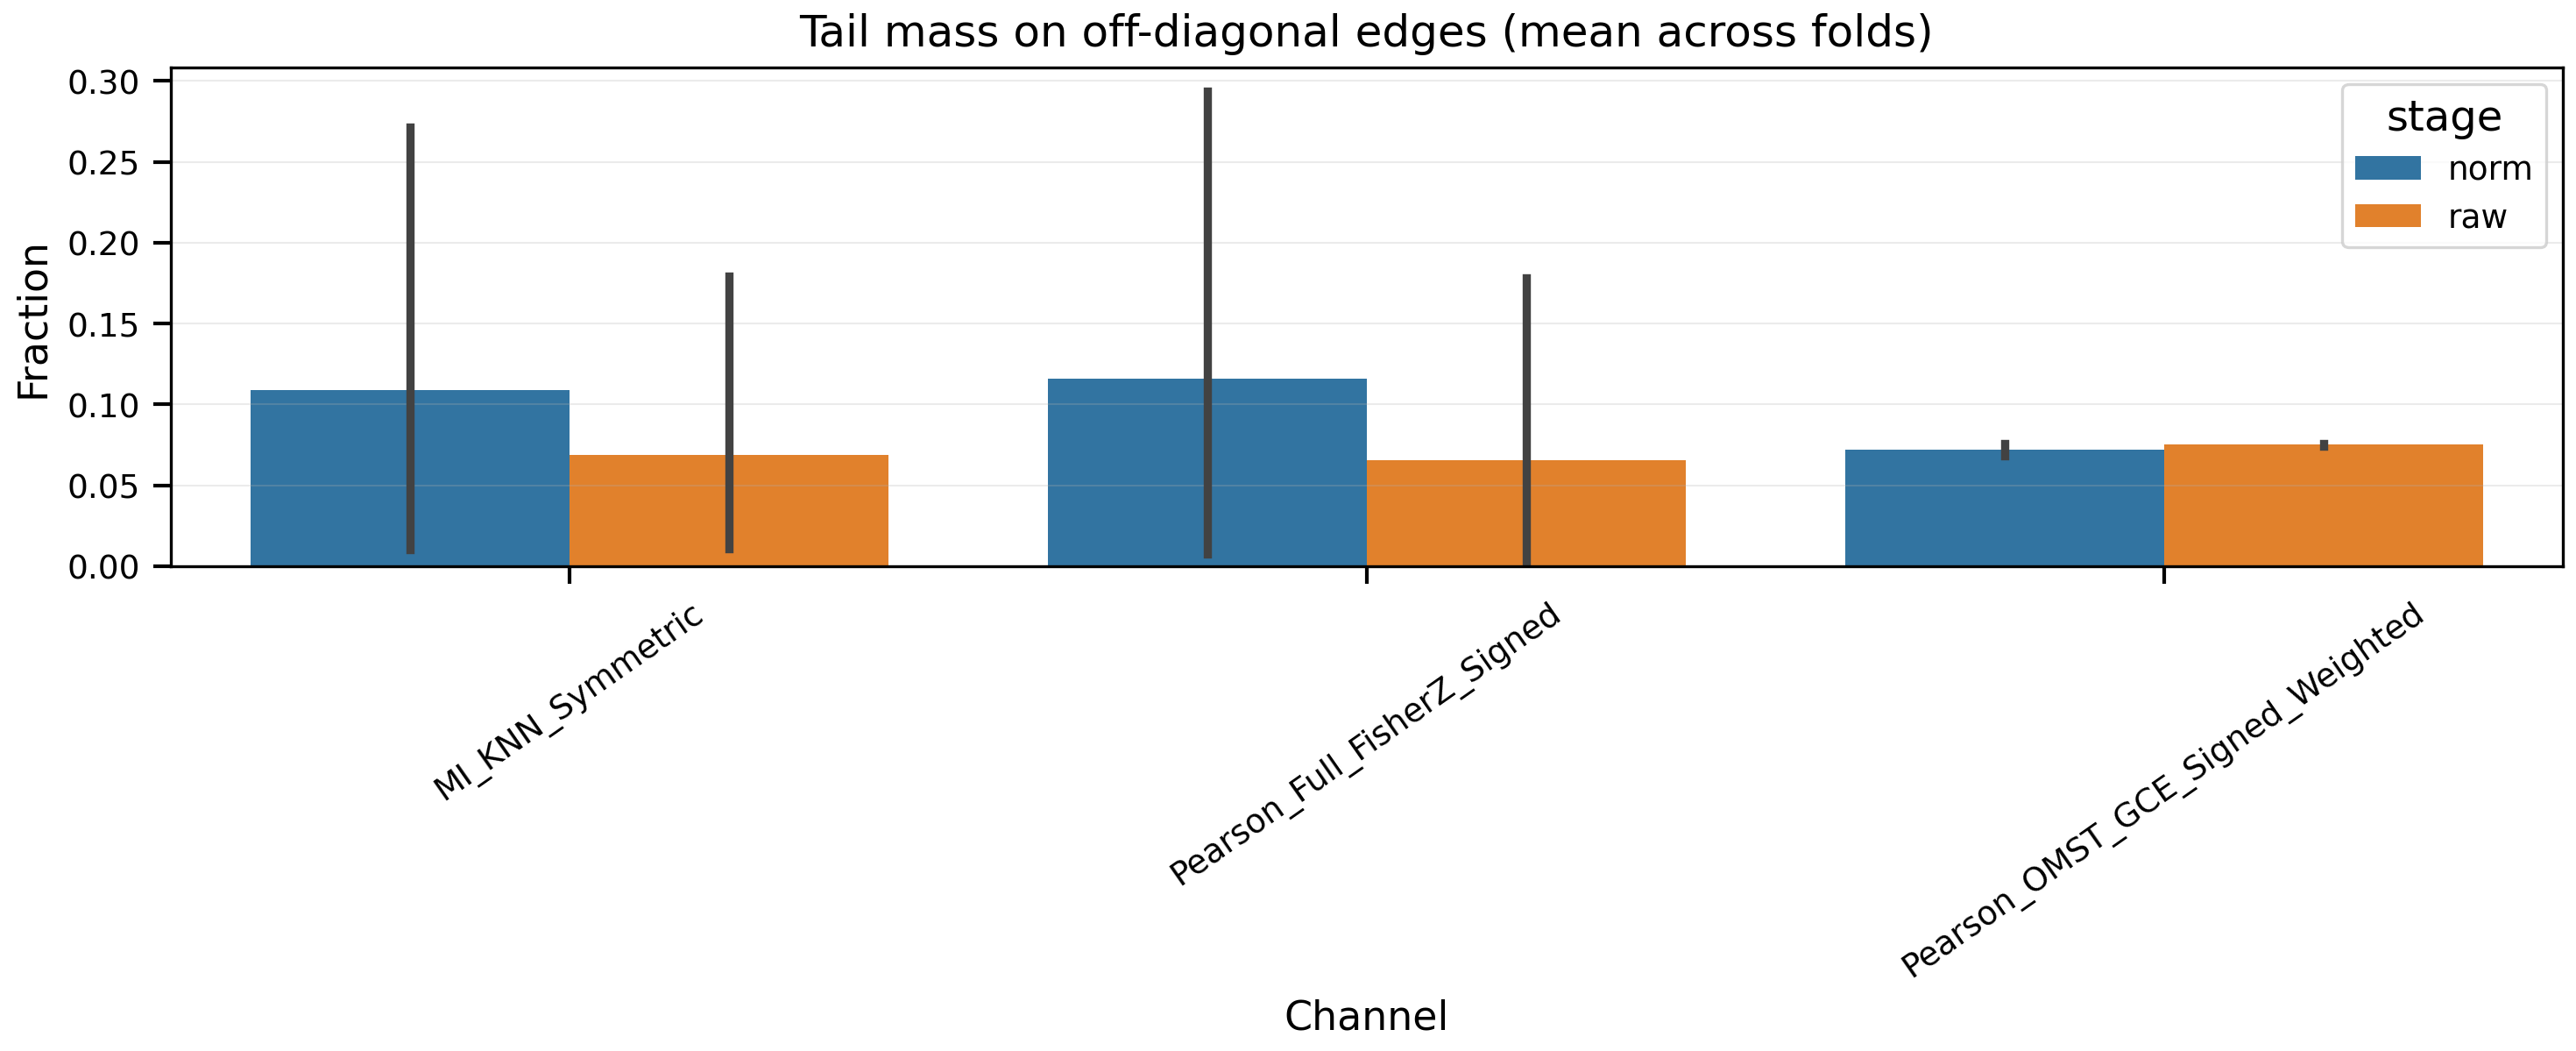

Saved: /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro/training_qc_paper_output/fig_tailmass_raw_vs_norm_logreg_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.png
Saved: /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro/training_qc_paper_output/fig_tailmass_raw_vs_norm_logreg_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.pdf
[OK] Tail-mass QC exported.


In [23]:
# Config
TAIL_N_SUBJ = int(os.environ.get("VAE_TAILMASS_N_SUBJ", "250"))
TAIL_SEED = int(os.environ.get("VAE_TAILMASS_SEED", "42"))
TAIL_THRESHOLDS = [1.0, 2.0, 3.0]
TAIL_PCTS = [0.1, 1, 5, 25, 50, 75, 95, 99, 99.9]

# Load tensor once (no broad globbing; path comes from config/run)
if GLOBAL_TENSOR_PATH is None or not Path(GLOBAL_TENSOR_PATH).exists():
    print("[SKIP] GLOBAL_TENSOR_PATH missing; tail-mass QC skipped.")
    tailmass_df = None
else:
    with np.load(Path(GLOBAL_TENSOR_PATH), allow_pickle=True) as npz:
        tensor_all = np.asarray(npz["global_tensor_data"])
        ch_names_npz = npz.get("channel_names", None)
    if ch_names_npz is not None:
        channel_names_master = [str(x) for x in np.asarray(ch_names_npz).ravel().tolist()]
    else:
        channel_names_master = list(DEFAULT_CHANNEL_NAMES)

    n_total, c_total, h, _ = tensor_all.shape
    ch_sel = run_args.get("channels_to_use", None)
    if ch_sel is None:
        ch_sel = list(range(c_total))
    ch_sel = [int(i) for i in ch_sel]
    ch_labels = [channel_names_master[i] if i < len(channel_names_master) else f"RawChan{i}" for i in ch_sel]

    rng = np.random.default_rng(TAIL_SEED)
    sample_idx = rng.choice(np.arange(n_total), size=min(TAIL_N_SUBJ, n_total), replace=False)
    raw_sub = tensor_all[sample_idx][:, ch_sel, :, :].astype(np.float32)

    def _stats_1d(v):
        v = np.asarray(v, dtype=float)
        v = v[np.isfinite(v)]
        if v.size == 0:
            return {"n": 0}
        out = {
            "n": int(v.size),
            "mean": float(np.mean(v)),
            "std": float(np.std(v, ddof=1)) if v.size > 1 else 0.0,
            "min": float(np.min(v)),
            "max": float(np.max(v)),
            "frac_outside_pm1": float(np.mean((v < -1) | (v > 1))),
        }
        q = np.percentile(v, TAIL_PCTS)
        for p, qq in zip(TAIL_PCTS, q):
            out[f"p{str(p).replace('.', 'p')}"] = float(qq)
        av = np.abs(v)
        for t in TAIL_THRESHOLDS:
            out[f"frac_abs_gt_{t:g}"] = float(np.mean(av > t))
        return out

    def _extract_edges(arr_4d, channel_idx_local, use_upper):
        A = arr_4d[:, channel_idx_local, :, :]
        if use_upper:
            iu, ju = np.triu_indices(A.shape[-1], k=1)
            return A[:, iu, ju].reshape(-1)
        m = ~np.eye(A.shape[-1], dtype=bool)
        return A[:, m].reshape(-1)

    rows = []
    for k in range(1, N_FOLDS + 1):
        norm_p = artifacts["per_fold"][k]["norm_params"]
        if norm_p is None or not Path(norm_p).exists():
            print(f"[WARN] Fold {k}: norm_params missing; skipping.")
            continue
        params_list = joblib.load(norm_p)
        norm_sub = apply_norm_batch(raw_sub, params_list)

        for c_loc, c_name in enumerate(ch_labels):
            is_symmetric = ("granger" not in c_name.lower())
            raw_vals = _extract_edges(raw_sub, c_loc, use_upper=is_symmetric)
            norm_vals = _extract_edges(norm_sub, c_loc, use_upper=is_symmetric)
            rows.append({"fold": k, "stage": "raw", "channel": c_name, **_stats_1d(raw_vals)})
            rows.append({"fold": k, "stage": "norm", "channel": c_name, **_stats_1d(norm_vals)})

    tailmass_df = pd.DataFrame(rows).sort_values(["channel", "stage", "fold"]).reset_index(drop=True)
    display(tailmass_df.head(12))
    tailmass_df.to_csv(OUTPUT_DIR / f"table_tailmass_raw_vs_norm_{TARGET_CLF}_{RUN_TAG}.csv", index=False)

    # Compact plot: tail fractions by channel (mean across folds)
    plot_rows = []
    for t in TAIL_THRESHOLDS:
        col = f"frac_abs_gt_{t:g}"
        if col in tailmass_df.columns:
            tmp = tailmass_df.groupby(["channel", "stage"], as_index=False)[col].mean()
            tmp["threshold"] = f"|x|>{t:g}"
            tmp = tmp.rename(columns={col: "fraction"})
            plot_rows.append(tmp)
    if plot_rows:
        plot_df = pd.concat(plot_rows, ignore_index=True)
        fig, ax = plt.subplots(figsize=(10, 4.2))
        sns.barplot(data=plot_df, x="channel", y="fraction", hue="stage", ax=ax)
        ax.set_title("Tail mass on off-diagonal edges (mean across folds)")
        ax.set_xlabel("Channel")
        ax.set_ylabel("Fraction")
        ax.tick_params(axis="x", rotation=35)
        ax.grid(True, axis="y", alpha=0.25)
        plt.tight_layout()
        show_fig(fig)
        save_figure(fig, OUTPUT_DIR / f"fig_tailmass_raw_vs_norm_{TARGET_CLF}_{RUN_TAG}", formats=FIG_FORMATS)

    print("[OK] Tail-mass QC exported.")

## §17 — Reconstruction Saturation QC (representative fold)

**What it measures:** decoder output range saturation on reconstructed connectomes.
**Why it matters:** excessive mass near clipping limits can indicate under/over-regularization.
**Method:** choose representative fold (best AUC for `TARGET_CLF`, fallback fold 1), run VAE forward on normalized sampled subjects, and quantify off-diagonal saturation/tails.
**Limitations:** this is a fold-level diagnostic (not a full-population estimate).

,fold,channel,n,p1,p5,p50,p95,p99,frac_abs_gt_0p95,frac_abs_gt_0p99,frac_abs_gt_1p00
0,1,Pearson_Full_FisherZ_Signed,1021800,-0.9978,-0.9825,0.1052,0.9677,0.9975,0.1598,0.0585,0.0
1,1,Pearson_OMST_GCE_Signed_Weighted,1021800,-0.5358,-0.4428,-0.1463,0.7450,0.9838,0.0186,0.0079,0.0
2,1,MI_KNN_Symmetric,1021800,-0.9901,-0.9560,-0.0207,0.9570,0.9989,0.1103,0.0347,0.0


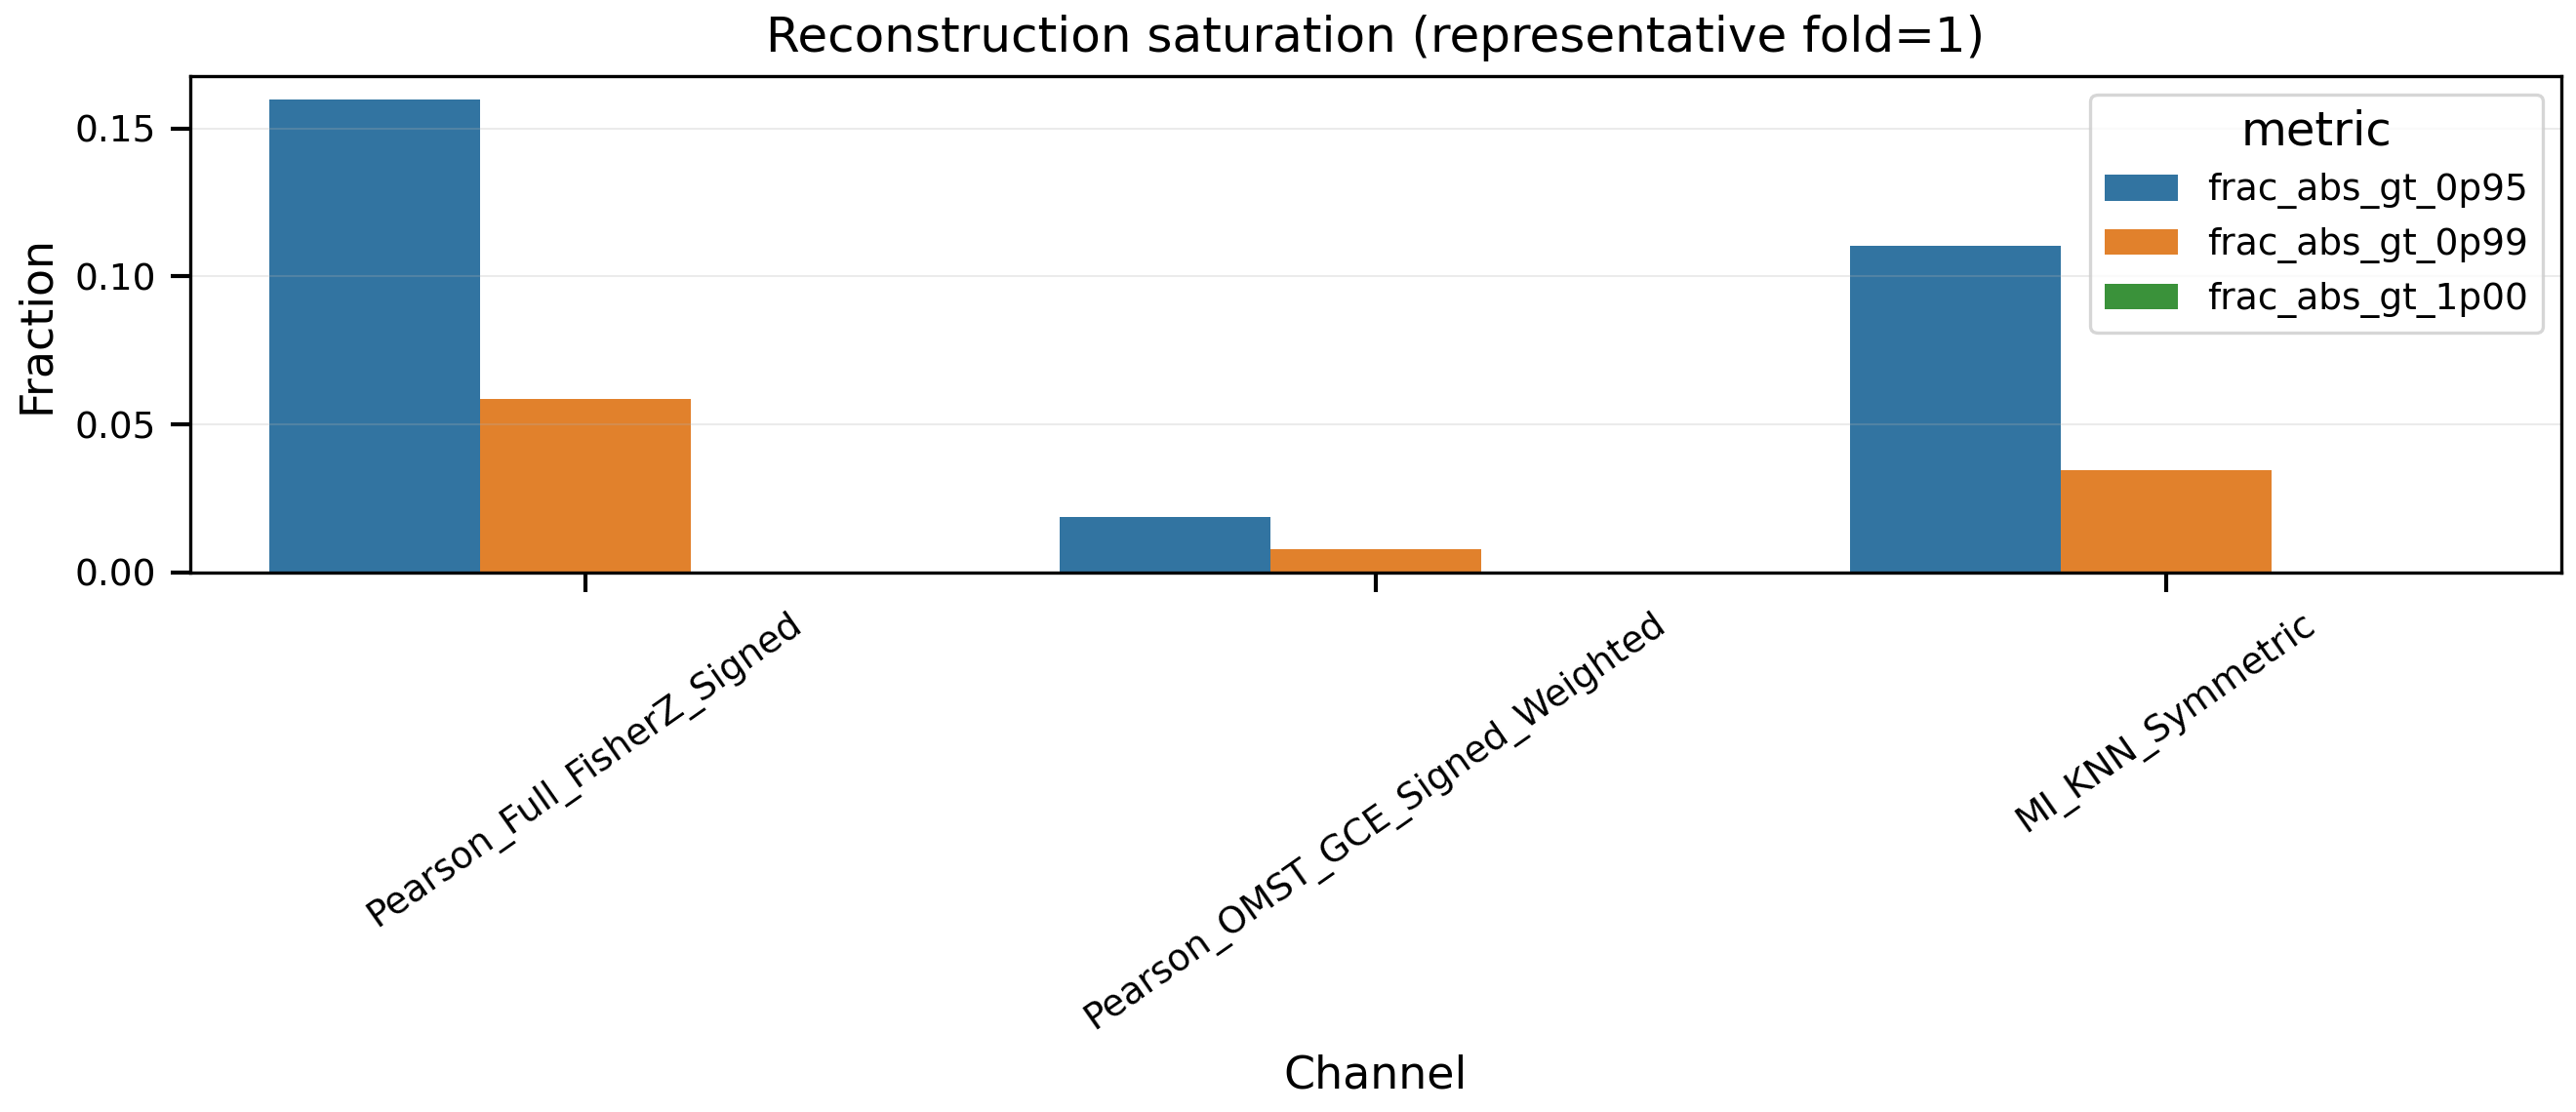

Saved: /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro/training_qc_paper_output/fig_recon_saturation_fold1_logreg_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.png
Saved: /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro/training_qc_paper_output/fig_recon_saturation_fold1_logreg_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.pdf
[OK] Reconstruction saturation QC exported for fold 1.


In [24]:
from betavae_xai.models import ConvolutionalVAE
import torch

RECON_N_SUBJ = int(os.environ.get("VAE_RECON_QC_N_SUBJ", "120"))
RECON_SEED = int(os.environ.get("VAE_RECON_QC_SEED", "123"))

if GLOBAL_TENSOR_PATH is None or not Path(GLOBAL_TENSOR_PATH).exists():
    print("[SKIP] GLOBAL_TENSOR_PATH missing; reconstruction saturation QC skipped.")
    recon_sat_df = None
else:
    # Representative fold = best AUC fold for TARGET_CLF
    auc_col = "auc_final" if "auc_final" in m_clf.columns else "auc"
    rep_fold = int(m_clf.loc[m_clf[auc_col].idxmax(), "fold"]) if m_clf[auc_col].notna().any() else 1
    if rep_fold not in artifacts["per_fold"]:
        rep_fold = 1

    fd = artifacts["per_fold"][rep_fold]["dir"]
    norm_path = artifacts["per_fold"][rep_fold]["norm_params"]
    ckpt_path = Path(fd) / f"vae_model_fold_{rep_fold}.pt"
    if norm_path is None or not Path(norm_path).exists() or not ckpt_path.exists():
        print(f"[SKIP] Missing fold {rep_fold} artifacts for recon QC.")
        recon_sat_df = None
    else:
        with np.load(Path(GLOBAL_TENSOR_PATH), allow_pickle=True) as npz:
            G = np.asarray(npz["global_tensor_data"])
            channel_names = npz.get("channel_names", None)
        n_all, c_all, h, _ = G.shape
        ch_sel = run_args.get("channels_to_use", None)
        if ch_sel is None:
            ch_sel = list(range(c_all))
        ch_sel = [int(i) for i in ch_sel]

        if channel_names is not None:
            ch_master = [str(x) for x in np.asarray(channel_names).ravel().tolist()]
        else:
            ch_master = list(DEFAULT_CHANNEL_NAMES)
        ch_labels = [ch_master[i] if i < len(ch_master) else f"RawChan{i}" for i in ch_sel]

        rng = np.random.default_rng(RECON_SEED)
        idx = rng.choice(np.arange(n_all), size=min(RECON_N_SUBJ, n_all), replace=False)
        X_raw = G[idx][:, ch_sel, :, :].astype(np.float32)
        params = joblib.load(norm_path)
        X_norm = apply_norm_batch(X_raw, params).astype(np.float32)

        # Build model from run args
        model = ConvolutionalVAE(
            input_channels=len(ch_sel),
            latent_dim=int(run_args.get("latent_dim", 128)),
            image_size=int(h),
            final_activation=str(run_args.get("vae_final_activation", "tanh")),
            intermediate_fc_dim_config=run_args.get("intermediate_fc_dim_vae", "quarter"),
            dropout_rate=float(run_args.get("dropout_rate_vae", 0.2)),
            use_layernorm_fc=bool(run_args.get("use_layernorm_vae_fc", False)),
            num_conv_layers_encoder=int(run_args.get("num_conv_layers_encoder", 4)),
            decoder_type=str(run_args.get("decoder_type", "convtranspose")),
        )
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        model.load_state_dict(torch.load(ckpt_path, map_location=device))
        model.eval()

        with torch.no_grad():
            xt = torch.from_numpy(X_norm).float().to(device)
            recon, _, _, _ = model(xt)
            recon_np = recon.detach().cpu().numpy()

        rows = []
        for c_loc, c_name in enumerate(ch_labels):
            is_symmetric = ("granger" not in c_name.lower())
            A = recon_np[:, c_loc, :, :]
            if is_symmetric:
                iu, ju = np.triu_indices(A.shape[-1], k=1)
                v = A[:, iu, ju].reshape(-1)
            else:
                m = ~np.eye(A.shape[-1], dtype=bool)
                v = A[:, m].reshape(-1)
            v = v[np.isfinite(v)]
            av = np.abs(v)
            rows.append({
                "fold": rep_fold,
                "channel": c_name,
                "n": int(v.size),
                "p1": float(np.percentile(v, 1)),
                "p5": float(np.percentile(v, 5)),
                "p50": float(np.percentile(v, 50)),
                "p95": float(np.percentile(v, 95)),
                "p99": float(np.percentile(v, 99)),
                "frac_abs_gt_0p95": float(np.mean(av > 0.95)),
                "frac_abs_gt_0p99": float(np.mean(av > 0.99)),
                "frac_abs_gt_1p00": float(np.mean(av > 1.00)),
            })

        recon_sat_df = pd.DataFrame(rows)
        display(recon_sat_df.round(4))
        recon_sat_df.to_csv(OUTPUT_DIR / f"table_recon_saturation_fold{rep_fold}_{TARGET_CLF}_{RUN_TAG}.csv", index=False)

        fig, ax = plt.subplots(figsize=(9, 4))
        plot_df = recon_sat_df.melt(
            id_vars=["channel"],
            value_vars=["frac_abs_gt_0p95", "frac_abs_gt_0p99", "frac_abs_gt_1p00"],
            var_name="metric", value_name="fraction"
        )
        sns.barplot(data=plot_df, x="channel", y="fraction", hue="metric", ax=ax)
        ax.set_title(f"Reconstruction saturation (representative fold={rep_fold})")
        ax.set_xlabel("Channel")
        ax.set_ylabel("Fraction")
        ax.tick_params(axis="x", rotation=35)
        ax.grid(True, axis="y", alpha=0.25)
        plt.tight_layout()
        show_fig(fig)
        save_figure(fig, OUTPUT_DIR / f"fig_recon_saturation_fold{rep_fold}_{TARGET_CLF}_{RUN_TAG}", formats=FIG_FORMATS)

        print(f"[OK] Reconstruction saturation QC exported for fold {rep_fold}.")

## §18 — Latent Dimension Information Profiling (IY vs IS)

**What it measures:** per-dimension information about diagnosis vs confounder.
**Why it matters:** identifies dimensions carrying biological signal vs site/scanner leakage.
**Method:** fold-test embeddings (μ), `mutual_info_classif` in bits, entropy-normalized scores, weighted aggregation across folds.
**Limitations:** MI estimates can be noisy for small fold sizes and imbalanced domains; rare confounder categories are collapsed (`MIN_N_DOMAIN`).

,dim,IY_bits_w,IS_bits_w,IY_norm_w,IS_norm_w,diff_norm_w,purity_norm_w,n_folds
19,19,0.1384,0.0128,0.1385,0.0109,0.1276,0.7666,5.0
188,188,0.1578,0.0448,0.1579,0.0400,0.1180,0.9144,5.0
89,89,0.1691,0.0737,0.1692,0.0635,0.1057,0.4495,5.0
121,121,0.1466,0.0468,0.1466,0.0433,0.1033,0.6456,5.0
66,66,0.1335,0.0410,0.1337,0.0366,0.0971,0.6261,5.0
224,224,0.1011,0.0067,0.1012,0.0057,0.0954,0.6011,5.0
231,231,0.1086,0.0174,0.1086,0.0157,0.0930,0.5939,5.0
3,3,0.1393,0.0620,0.1394,0.0531,0.0863,0.6752,5.0
109,109,0.1242,0.0403,0.1244,0.0385,0.0859,0.4298,5.0
180,180,0.1332,0.0635,0.1333,0.0547,0.0786,0.6941,5.0


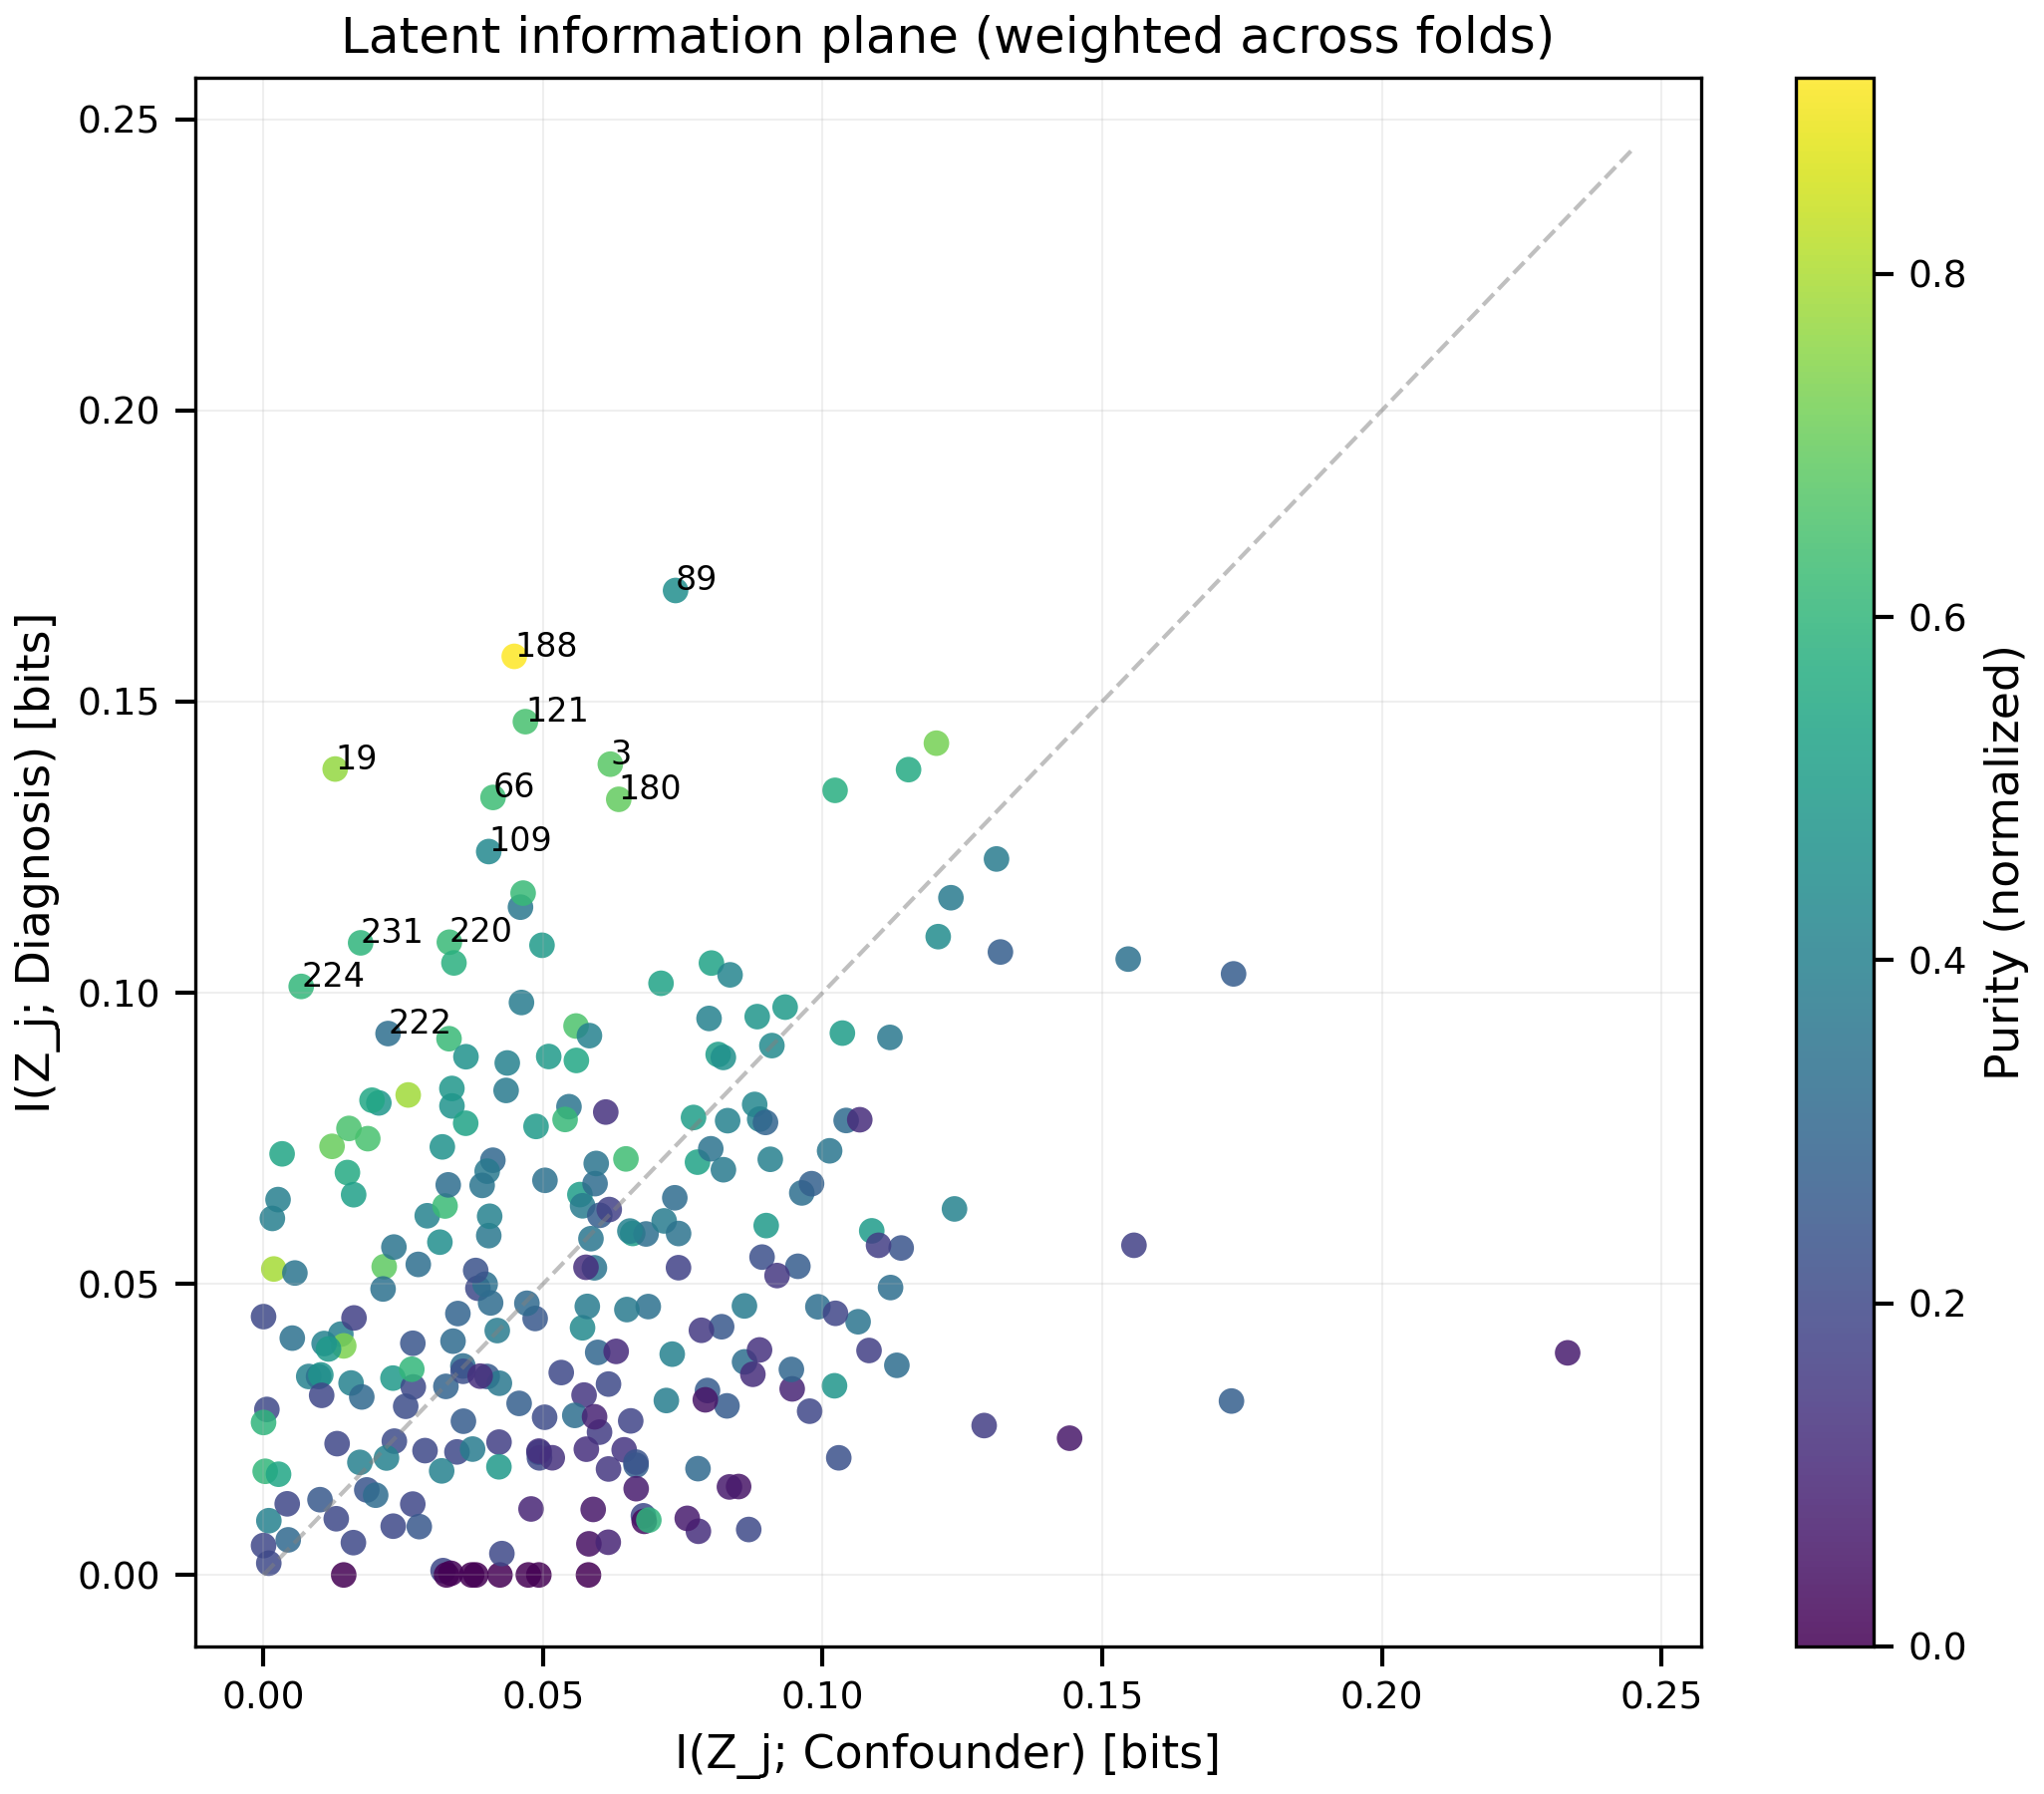

Saved: /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro/training_qc_paper_output/fig_information_plane_latent_dims_logreg_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.png
Saved: /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro/training_qc_paper_output/fig_information_plane_latent_dims_logreg_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.pdf
[OK] Latent MI per-dimension profiling exported.


In [25]:
LATENT_MI_TOPK = int(os.environ.get("VAE_LATENT_MI_TOPK", "30"))
MI_N_NEIGHBORS = int(os.environ.get("VAE_MI_N_NEIGHBORS", "3"))
EPS = 1e-8

if GLOBAL_TENSOR_PATH is None or not Path(GLOBAL_TENSOR_PATH).exists() or _meta is None:
    print("[SKIP] Missing GLOBAL_TENSOR_PATH or metadata; latent MI profiling skipped.")
    mi_per_dim_df = None
    mi_rank_df = None
    fold_latent_cache = {}
else:
    # Metadata aligned to tensor order (single source)
    meta_aligned = build_metadata_aligned_to_tensor(Path(GLOBAL_TENSOR_PATH), Path(METADATA_PATH))
    if "ResearchGroup" in meta_aligned.columns and "ResearchGroup_Mapped" not in meta_aligned.columns:
        rg = meta_aligned["ResearchGroup"].astype(str).str.strip()
        map_rg = {"CN": "CN", "AD": "AD", "Control": "CN", "Patient": "AD"}
        meta_aligned["ResearchGroup_Mapped"] = rg.map(map_rg).fillna(rg)

    # confounder in aligned metadata
    conf_col_aligned = detect_confounder_column(meta_aligned)
    if conf_col_aligned is None:
        meta_aligned["_confounder"] = "Unknown"
    else:
        meta_aligned["_confounder"] = meta_aligned[conf_col_aligned].fillna("Unknown").astype(str)
    vc = meta_aligned["_confounder"].value_counts(dropna=False)
    keep = vc[vc >= MIN_N_DOMAIN].index
    meta_aligned["_confounder_collapsed"] = meta_aligned["_confounder"].where(meta_aligned["_confounder"].isin(keep), "Other")

    with np.load(Path(GLOBAL_TENSOR_PATH), allow_pickle=True) as npz:
        G = np.asarray(npz["global_tensor_data"])
        chn = npz.get("channel_names", None)
    n_total, c_total, h, _ = G.shape
    ch_sel = run_args.get("channels_to_use", None)
    if ch_sel is None:
        ch_sel = list(range(c_total))
    ch_sel = [int(i) for i in ch_sel]

    def _load_test_tensor_idx(fold_dir: Path):
        csv_p = fold_dir / "test_subjects_fold.csv"
        npy_p = fold_dir / "test_tensor_idx.npy"
        if csv_p.exists():
            d = pd.read_csv(csv_p)
            if "tensor_idx" in d.columns:
                return d["tensor_idx"].astype(int).to_numpy()
        if npy_p.exists():
            return np.load(npy_p).astype(int)
        return np.array([], dtype=int)

    def _instantiate_fold_model():
        return ConvolutionalVAE(
            input_channels=len(ch_sel),
            latent_dim=int(run_args.get("latent_dim", 128)),
            image_size=int(h),
            final_activation=str(run_args.get("vae_final_activation", "tanh")),
            intermediate_fc_dim_config=run_args.get("intermediate_fc_dim_vae", "quarter"),
            dropout_rate=float(run_args.get("dropout_rate_vae", 0.2)),
            use_layernorm_fc=bool(run_args.get("use_layernorm_vae_fc", False)),
            num_conv_layers_encoder=int(run_args.get("num_conv_layers_encoder", 4)),
            decoder_type=str(run_args.get("decoder_type", "convtranspose")),
        )

    fold_latent_cache = {}
    rows = []
    for k in range(1, N_FOLDS + 1):
        fd = artifacts["per_fold"][k]["dir"]
        norm_p = artifacts["per_fold"][k]["norm_params"]
        ckpt_p = Path(fd) / f"vae_model_fold_{k}.pt"
        test_idx = _load_test_tensor_idx(Path(fd))

        if test_idx.size == 0 or norm_p is None or not Path(norm_p).exists() or not ckpt_p.exists():
            print(f"[WARN] Fold {k}: missing test indices or model/norm artifacts; skipped.")
            continue

        params = joblib.load(norm_p)
        X = G[test_idx][:, ch_sel, :, :].astype(np.float32)
        Xn = apply_norm_batch(X, params).astype(np.float32)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = _instantiate_fold_model().to(device)
        model.load_state_dict(torch.load(ckpt_p, map_location=device))
        model.eval()
        with torch.no_grad():
            xt = torch.from_numpy(Xn).float().to(device)
            _, mu, _, _ = model(xt)
            Z = mu.detach().cpu().numpy()

        md = meta_aligned.set_index("tensor_idx").loc[test_idx].reset_index()
        y = md["ResearchGroup_Mapped"].astype(str).values
        y_bin = pd.Series(y).map({"CN": 0, "AD": 1}).values
        s = md["_confounder_collapsed"].astype(str).values

        valid = np.isfinite(y_bin)
        y_bin = y_bin[valid].astype(int)
        s = s[valid]
        Z = Z[valid]
        n_test = int(Z.shape[0])
        if n_test < 10 or len(np.unique(y_bin)) < 2 or len(np.unique(s)) < 2:
            print(f"[WARN] Fold {k}: insufficient class support for MI; skipped.")
            continue

        s_int, s_labels = pd.factorize(s)
        H_y = entropy_bits(y_bin)
        H_s = entropy_bits(s_int)
        mi_y_nats = mutual_info_classif(Z, y_bin, random_state=42, n_neighbors=MI_N_NEIGHBORS)
        mi_s_nats = mutual_info_classif(Z, s_int, random_state=42, n_neighbors=MI_N_NEIGHBORS)
        IY_bits = mi_y_nats / np.log(2.0)
        IS_bits = mi_s_nats / np.log(2.0)
        IY_norm = IY_bits / max(H_y, EPS) if np.isfinite(H_y) else np.full_like(IY_bits, np.nan)
        IS_norm = IS_bits / max(H_s, EPS) if np.isfinite(H_s) else np.full_like(IS_bits, np.nan)
        diff_norm = IY_norm - IS_norm
        purity = IY_norm / (IY_norm + IS_norm + EPS)

        for j in range(Z.shape[1]):
            rows.append({
                "fold": int(k), "n_test": n_test, "dim": int(j),
                "IY_bits": float(IY_bits[j]), "IS_bits": float(IS_bits[j]),
                "H_Y_bits": float(H_y), "H_S_bits": float(H_s),
                "IY_norm": float(IY_norm[j]), "IS_norm": float(IS_norm[j]),
                "diff_norm": float(diff_norm[j]), "purity_norm": float(purity[j]),
            })

        fold_latent_cache[int(k)] = {
            "Z": Z,
            "y": y_bin,
            "s": s_int,
            "conf_labels": s_labels.tolist(),
        }

    mi_per_dim_df = pd.DataFrame(rows)
    if mi_per_dim_df.empty:
        print("[SKIP] No fold produced valid MI estimates.")
        mi_rank_df = None
    else:
        def _wmean(g, col):
            w = g["n_test"].to_numpy(dtype=float)
            x = g[col].to_numpy(dtype=float)
            m = np.isfinite(x) & np.isfinite(w)
            if not np.any(m):
                return np.nan
            return float(np.average(x[m], weights=w[m]))

        mi_rank_df = (
            mi_per_dim_df.groupby("dim", as_index=False)
            .apply(lambda g: pd.Series({
                "IY_bits_w": _wmean(g, "IY_bits"),
                "IS_bits_w": _wmean(g, "IS_bits"),
                "IY_norm_w": _wmean(g, "IY_norm"),
                "IS_norm_w": _wmean(g, "IS_norm"),
                "diff_norm_w": _wmean(g, "diff_norm"),
                "purity_norm_w": _wmean(g, "purity_norm"),
                "n_folds": int(g["fold"].nunique()),
            }))
            .reset_index(drop=True)
            .sort_values(["diff_norm_w", "IY_bits_w"], ascending=False)
        )

        mi_per_dim_df.to_csv(OUTPUT_DIR / f"table_latent_mi_per_dim_by_fold_{TARGET_CLF}_{RUN_TAG}.csv", index=False)
        mi_rank_df.to_csv(OUTPUT_DIR / f"table_latent_mi_ranking_{TARGET_CLF}_{RUN_TAG}.csv", index=False)
        mi_rank_df.head(LATENT_MI_TOPK).to_csv(OUTPUT_DIR / f"table_latent_mi_top{LATENT_MI_TOPK}_{TARGET_CLF}_{RUN_TAG}.csv", index=False)

        display(mi_rank_df.head(15).round(4))

        # Information plane
        fig, ax = plt.subplots(figsize=(7.2, 6.2))
        sc = ax.scatter(
            mi_rank_df["IS_bits_w"], mi_rank_df["IY_bits_w"],
            c=mi_rank_df["purity_norm_w"], cmap="viridis", s=38, alpha=0.85, edgecolors="none"
        )
        top_for_labels = mi_rank_df.head(min(12, len(mi_rank_df)))
        for _, r in top_for_labels.iterrows():
            ax.text(r["IS_bits_w"], r["IY_bits_w"], str(int(r["dim"])), fontsize=8)
        lim = max(float(mi_rank_df["IS_bits_w"].max()), float(mi_rank_df["IY_bits_w"].max())) * 1.05
        ax.plot([0, lim], [0, lim], "--", color="gray", alpha=0.5, lw=1)
        ax.set_xlabel("I(Z_j; Confounder) [bits]")
        ax.set_ylabel("I(Z_j; Diagnosis) [bits]")
        ax.set_title("Latent information plane (weighted across folds)")
        cbar = plt.colorbar(sc, ax=ax)
        cbar.set_label("Purity (normalized)")
        ax.grid(True, alpha=0.2)
        plt.tight_layout()
        show_fig(fig)
        save_figure(fig, OUTPUT_DIR / f"fig_information_plane_latent_dims_{TARGET_CLF}_{RUN_TAG}", formats=FIG_FORMATS)

        print("[OK] Latent MI per-dimension profiling exported.")

## §19 — Purified-subspace Ablation (full Z vs top-K clean dims)

**What it measures:** whether removing confounder-heavy dimensions preserves diagnosis AUC while reducing confounder decodability.
**Why it matters:** validates disentanglement quality beyond descriptive MI rankings.
**Method:** per-fold paired evaluation with the same CV protocol for full vs top-K dimensions; Wilcoxon signed-rank across folds.
**Limitations:** with N≈5 folds, inferential power is low; report effect directions and p-values cautiously.

,fold,n_train,n_test,k_dims,auc_diag_full,auc_diag_topk,delta_auc_diag,n_confounder_classes_train,ba_conf_full,ba_conf_topk,delta_ba_conf,chance_conf_train
0,1,146,37,30,0.8684,0.8099,-0.0585,3,0.4444,0.4111,-0.0333,0.3333
1,2,146,37,30,0.7836,0.8450,0.0614,3,0.7619,0.7750,0.0131,0.3333
2,3,146,37,30,0.7368,0.7982,0.0614,3,0.7274,0.6637,-0.0637,0.3333
3,4,147,36,30,0.7531,0.7377,-0.0154,3,0.7948,0.8214,0.0267,0.3333
4,5,147,36,30,0.7554,0.8514,0.0960,3,0.7372,0.6111,-0.1261,0.3333


,k_dims,n_folds_auc,mean_auc_full,mean_auc_topk,mean_delta_auc,p_wilcoxon_auc,n_folds_ba,mean_ba_full,mean_ba_topk,mean_delta_ba,p_wilcoxon_ba,note
0,30,5,0.7795,0.8085,0.029,0.3125,5,0.6931,0.6565,-0.0367,0.3125,Intra-fold (train_dev→test) embeddings; Top-K ...


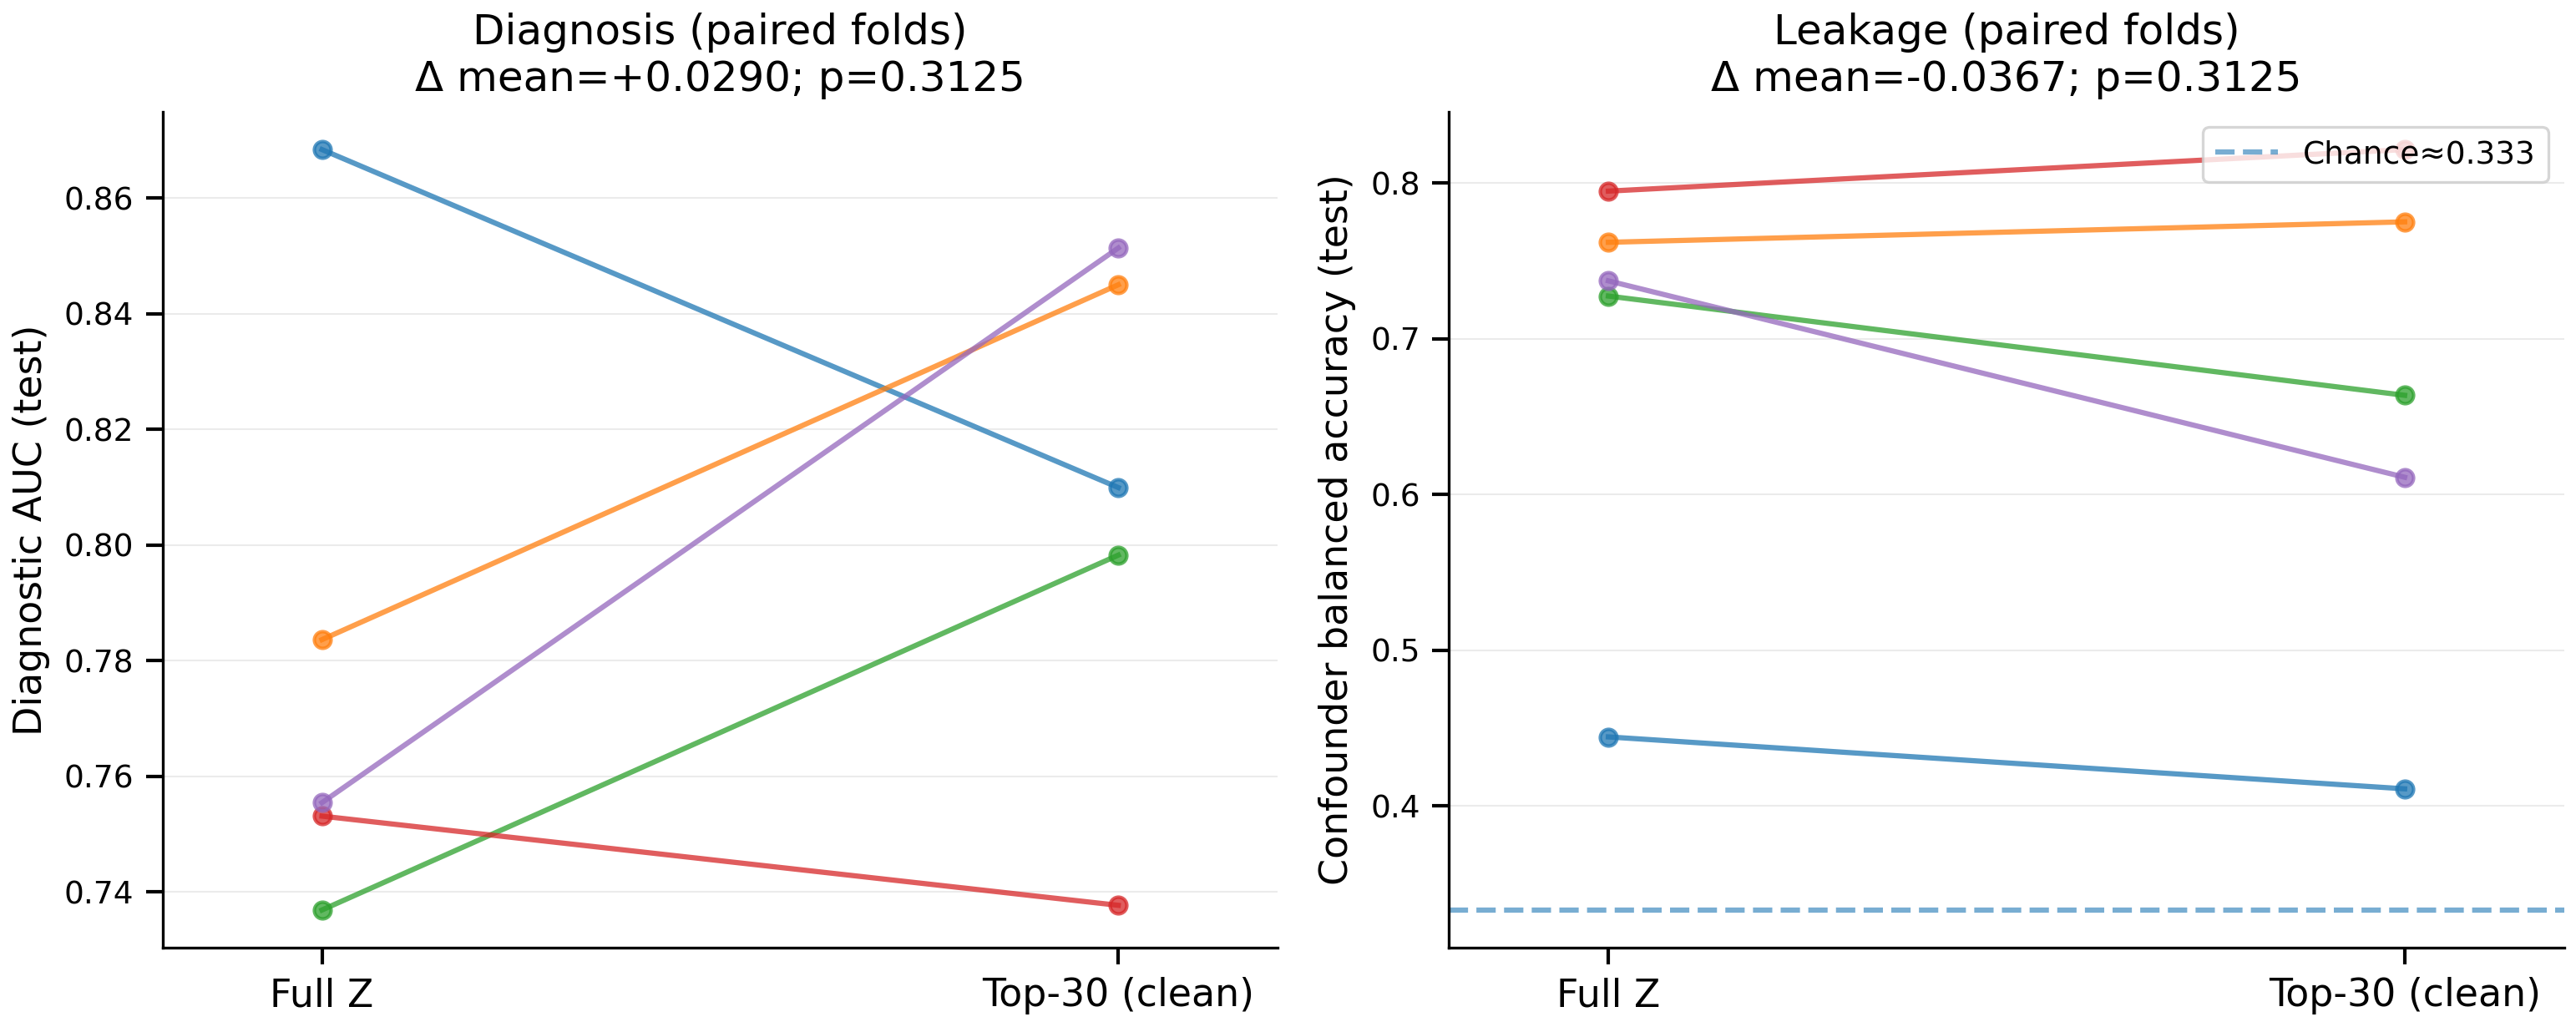

Saved: /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro/training_qc_paper_output/fig_subspace_ablation_intrafold_slopes_logreg_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.png
Saved: /home/diego/proyectos/vae_AD/results/vae_3channels_beta65_pro/training_qc_paper_output/fig_subspace_ablation_intrafold_slopes_logreg_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.pdf
[OK] Intra-fold purified-subspace ablation exported → table_subspace_ablation_intrafold_full_vs_topk_logreg_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.15_ln0_outer5x1_scoreroc_auc.csv


In [26]:
# ==============================================================================
# §19 — Purified-subspace Ablation (physically consistent, no cross-encoder mixing)
# Train/dev → test within EACH fold (same encoder + same coordinate system).
# Top-K “clean” dims are selected using TRAIN ONLY (MI(Z;Y) vs MI(Z;S)).
# ==============================================================================

import os
import numpy as np
import pandas as pd

from pathlib import Path
from scipy.stats import wilcoxon
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, balanced_accuracy_score

import torch
from betavae_xai.models import ConvolutionalVAE

# -----------------------
# Config
# -----------------------
SUBSPACE_TOPK   = int(os.environ.get("VAE_SUBSPACE_TOPK", "30"))
MI_N_NEIGHBORS  = int(os.environ.get("VAE_MI_N_NEIGHBORS", "3"))
EPS             = 1e-8

# -----------------------
# Preconditions
# -----------------------
if GLOBAL_TENSOR_PATH is None or not Path(GLOBAL_TENSOR_PATH).exists():
    print("[SKIP] GLOBAL_TENSOR_PATH missing; cannot compute fold embeddings for ablation.")
    subspace_df = None

elif METADATA_PATH is None or not Path(METADATA_PATH).exists():
    print("[SKIP] METADATA_PATH missing; cannot build confounder labels for ablation.")
    subspace_df = None

else:
    # -----------------------
    # Load aligned metadata (single source of truth, aligned to tensor_idx)
    # -----------------------
    meta_aligned = build_metadata_aligned_to_tensor(Path(GLOBAL_TENSOR_PATH), Path(METADATA_PATH)).copy()

    # Ensure diagnosis label
    if "ResearchGroup_Mapped" not in meta_aligned.columns:
        if "ResearchGroup" in meta_aligned.columns:
            rg = meta_aligned["ResearchGroup"].astype(str).str.strip()
            map_rg = {"CN": "CN", "AD": "AD", "Control": "CN", "Patient": "AD"}
            meta_aligned["ResearchGroup_Mapped"] = rg.map(map_rg).fillna(rg)
        else:
            raise ValueError("meta_aligned must contain ResearchGroup or ResearchGroup_Mapped for diagnosis labels.")

    # Confounder column (e.g., Manufacturer/Vendor)
    conf_col_aligned = detect_confounder_column(meta_aligned)
    if conf_col_aligned is None:
        meta_aligned["_confounder"] = "Unknown"
    else:
        meta_aligned["_confounder"] = meta_aligned[conf_col_aligned].fillna("Unknown").astype(str)

    # Collapse rare categories globally (robustness)
    vc = meta_aligned["_confounder"].value_counts(dropna=False)
    keep = vc[vc >= MIN_N_DOMAIN].index
    meta_aligned["_confounder_collapsed"] = meta_aligned["_confounder"].where(
        meta_aligned["_confounder"].isin(keep), "Other"
    )

    # Index for fast lookup
    if "tensor_idx" not in meta_aligned.columns:
        raise ValueError("meta_aligned must contain 'tensor_idx' column.")
    meta_ix = meta_aligned.set_index("tensor_idx", drop=False)

    # -----------------------
    # Load global tensor once
    # -----------------------
    with np.load(Path(GLOBAL_TENSOR_PATH), allow_pickle=True) as npz:
        G = np.asarray(npz["global_tensor_data"])  # shape: (N, C, H, H)
        chn = npz.get("channel_names", None)

    n_total, c_total, h, _ = G.shape

    # Channels used in the run
    ch_sel = run_args.get("channels_to_use", None)
    if ch_sel is None:
        ch_sel = list(range(c_total))
    ch_sel = [int(i) for i in ch_sel]

    # Model factory (must match training args)
    def _instantiate_fold_model():
        return ConvolutionalVAE(
            input_channels=len(ch_sel),
            latent_dim=int(run_args.get("latent_dim", 128)),
            image_size=int(h),
            final_activation=str(run_args.get("vae_final_activation", "tanh")),
            intermediate_fc_dim_config=run_args.get("intermediate_fc_dim_vae", "quarter"),
            dropout_rate=float(run_args.get("dropout_rate_vae", 0.2)),
            use_layernorm_fc=bool(run_args.get("use_layernorm_vae_fc", False)),
            num_conv_layers_encoder=int(run_args.get("num_conv_layers_encoder", 4)),
            decoder_type=str(run_args.get("decoder_type", "convtranspose")),
        )

    # Robust fold index loaders
    def _load_tensor_idx_from_fold(fold_dir: Path, kind: str) -> np.ndarray:
        """
        kind: 'train_dev' or 'test'
        expects: train_dev_subjects_fold.csv / test_subjects_fold.csv with tensor_idx column.
        """
        cand = []
        if kind == "train_dev":
            cand += ["train_dev_subjects_fold.csv", "train_subjects_fold.csv", "train_dev.csv"]
        else:
            cand += ["test_subjects_fold.csv", "test_subjects.csv", "test.csv"]

        for name in cand:
            p = fold_dir / name
            if p.exists():
                d = pd.read_csv(p)
                if "tensor_idx" in d.columns:
                    return d["tensor_idx"].astype(int).to_numpy()
        # fallback: npy
        npy = fold_dir / f"{kind}_tensor_idx.npy"
        if npy.exists():
            return np.load(npy).astype(int)

        return np.array([], dtype=int)

    # Helpers
    def _encode_y(md: pd.DataFrame) -> np.ndarray:
        y = md["ResearchGroup_Mapped"].astype(str).str.strip()
        yb = y.map({"CN": 0, "AD": 1})
        return yb.to_numpy()

    def _entropy_bits_from_int_labels(x_int: np.ndarray) -> float:
        x_int = np.asarray(x_int, dtype=int)
        x_int = x_int[np.isfinite(x_int)]
        if x_int.size == 0:
            return np.nan
        return float(entropy_bits(x_int))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    rows = []

    # -----------------------
    # Main loop: per-fold ablation (no cross-fold latent mixing)
    # -----------------------
    for k in range(1, N_FOLDS + 1):
        fd = Path(artifacts["per_fold"][k]["dir"])
        norm_p = artifacts["per_fold"][k]["norm_params"]
        ckpt_p = fd / f"vae_model_fold_{k}.pt"

        tr_idx = _load_tensor_idx_from_fold(fd, "train_dev")
        te_idx = _load_tensor_idx_from_fold(fd, "test")

        if tr_idx.size == 0 or te_idx.size == 0:
            print(f"[WARN] Fold {k}: missing train/test tensor_idx; skipped.")
            continue
        if norm_p is None or (not Path(norm_p).exists()) or (not ckpt_p.exists()):
            print(f"[WARN] Fold {k}: missing norm params or checkpoint; skipped.")
            continue

        # Labels from aligned metadata
        md_tr = meta_ix.loc[tr_idx].copy()
        md_te = meta_ix.loc[te_idx].copy()

        y_tr = _encode_y(md_tr)
        y_te = _encode_y(md_te)

        # Drop NaNs (if any)
        m_tr = np.isfinite(y_tr)
        m_te = np.isfinite(y_te)
        y_tr = y_tr[m_tr].astype(int)
        y_te = y_te[m_te].astype(int)
        tr_idx_eff = tr_idx[m_tr]
        te_idx_eff = te_idx[m_te]

        if len(np.unique(y_tr)) < 2 or len(np.unique(y_te)) < 2:
            print(f"[WARN] Fold {k}: insufficient diagnosis support; skipped.")
            continue

        s_tr = md_tr.loc[tr_idx_eff, "_confounder_collapsed"].astype(str).to_numpy()
        s_te = md_te.loc[te_idx_eff, "_confounder_collapsed"].astype(str).to_numpy()

        # Encode confounder with TRAIN-only vocabulary; unseen test classes masked out
        s_tr_int, s_labels = pd.factorize(s_tr)
        s_te_int = pd.Series(s_te).map({lab: i for i, lab in enumerate(s_labels)}).fillna(-1).astype(int).to_numpy()
        seen_mask_te = (s_te_int >= 0)

        # Need at least 2 confounder classes in TRAIN for leakage model
        n_s_classes_tr = int(len(np.unique(s_tr_int)))
        can_leak = (n_s_classes_tr >= 2)

        # Load + normalize tensors for this fold
        params = joblib.load(norm_p)

        Xtr = G[tr_idx_eff][:, ch_sel, :, :].astype(np.float32)
        Xte = G[te_idx_eff][:, ch_sel, :, :].astype(np.float32)
        Xtr_n = apply_norm_batch(Xtr, params).astype(np.float32)
        Xte_n = apply_norm_batch(Xte, params).astype(np.float32)

        # Compute μ embeddings for TRAIN and TEST (same encoder)
        model = _instantiate_fold_model().to(device)
        model.load_state_dict(torch.load(ckpt_p, map_location=device))
        model.eval()

        with torch.no_grad():
            Ztr = model(torch.from_numpy(Xtr_n).to(device))[1].detach().cpu().numpy()
            Zte = model(torch.from_numpy(Xte_n).to(device))[1].detach().cpu().numpy()

        # -----------------------
        # Select Top-K dims using TRAIN ONLY (MI plane)
        # -----------------------
        H_y = _entropy_bits_from_int_labels(y_tr)
        H_s = _entropy_bits_from_int_labels(s_tr_int) if can_leak else np.nan

        mi_y_nats = mutual_info_classif(Ztr, y_tr, random_state=42, n_neighbors=MI_N_NEIGHBORS)
        IY_bits = mi_y_nats / np.log(2.0)

        if can_leak:
            mi_s_nats = mutual_info_classif(Ztr, s_tr_int, random_state=42, n_neighbors=MI_N_NEIGHBORS)
            IS_bits = mi_s_nats / np.log(2.0)
        else:
            IS_bits = np.zeros_like(IY_bits)

        IY_norm = IY_bits / max(H_y, EPS) if np.isfinite(H_y) else np.full_like(IY_bits, np.nan)
        IS_norm = IS_bits / max(H_s, EPS) if np.isfinite(H_s) else np.zeros_like(IY_norm)

        diff_norm = IY_norm - IS_norm
        purity = IY_norm / (IY_norm + IS_norm + EPS)

        # Rank: maximize (IY_norm - IS_norm), tie-breaker by purity then IY_bits
        order = np.lexsort((-IY_bits, -purity, -diff_norm))[::-1]
        top_dims = order[:max(1, min(SUBSPACE_TOPK, Ztr.shape[1]))].astype(int)

        # -----------------------
        # Diagnosis models: full Z vs Top-K
        # -----------------------
        clf_y_full = LogisticRegression(max_iter=5000, solver="lbfgs", class_weight="balanced")
        clf_y_full.fit(Ztr, y_tr)
        p_full = clf_y_full.predict_proba(Zte)[:, 1]
        auc_full = float(roc_auc_score(y_te, p_full))

        clf_y_k = LogisticRegression(max_iter=5000, solver="lbfgs", class_weight="balanced")
        clf_y_k.fit(Ztr[:, top_dims], y_tr)
        p_k = clf_y_k.predict_proba(Zte[:, top_dims])[:, 1]
        auc_k = float(roc_auc_score(y_te, p_k))

        # -----------------------
        # Leakage models (confounder decodability): full Z vs Top-K
        # (train on train_dev, eval on test; mask unseen confounder classes)
        # -----------------------
        ba_full, ba_k = np.nan, np.nan
        if can_leak and (seen_mask_te.sum() >= 10) and (len(np.unique(s_te_int[seen_mask_te])) >= 2):
            clf_s_full = LogisticRegression(
                max_iter=7000, solver="lbfgs", multi_class="auto", class_weight="balanced"
            )
            clf_s_full.fit(Ztr, s_tr_int)
            s_hat_full = clf_s_full.predict(Zte[seen_mask_te])
            ba_full = float(balanced_accuracy_score(s_te_int[seen_mask_te], s_hat_full))

            clf_s_k = LogisticRegression(
                max_iter=7000, solver="lbfgs", multi_class="auto", class_weight="balanced"
            )
            clf_s_k.fit(Ztr[:, top_dims], s_tr_int)
            s_hat_k = clf_s_k.predict(Zte[seen_mask_te][:, top_dims])
            ba_k = float(balanced_accuracy_score(s_te_int[seen_mask_te], s_hat_k))

        rows.append({
            "fold": int(k),
            "n_train": int(Ztr.shape[0]),
            "n_test": int(Zte.shape[0]),
            "k_dims": int(len(top_dims)),
            "auc_diag_full": auc_full,
            "auc_diag_topk": auc_k,
            "delta_auc_diag": auc_k - auc_full,
            "n_confounder_classes_train": n_s_classes_tr,
            "ba_conf_full": ba_full,
            "ba_conf_topk": ba_k,
            "delta_ba_conf": (ba_k - ba_full) if np.isfinite(ba_k) and np.isfinite(ba_full) else np.nan,
            "chance_conf_train": (1.0 / n_s_classes_tr) if n_s_classes_tr >= 2 else np.nan,
        })

    subspace_df = pd.DataFrame(rows)

    if subspace_df.empty:
        print("[SKIP] No fold could be evaluated for purified-subspace ablation.")
    else:
        display(subspace_df.round(4))
        out_main = OUTPUT_DIR / f"table_subspace_ablation_intrafold_full_vs_topk_{TARGET_CLF}_{RUN_TAG}.csv"
        subspace_df.to_csv(out_main, index=False)

        # Paired tests (small-N): Wilcoxon signed-rank
        p_auc = np.nan
        _a = subspace_df[["auc_diag_full", "auc_diag_topk"]].dropna()
        if len(_a) >= 3:
            try:
                p_auc = float(wilcoxon(_a["auc_diag_topk"], _a["auc_diag_full"], alternative="two-sided").pvalue)
            except Exception:
                p_auc = np.nan

        p_ba = np.nan
        _b = subspace_df[["ba_conf_full", "ba_conf_topk"]].dropna()
        if len(_b) >= 3:
            try:
                p_ba = float(wilcoxon(_b["ba_conf_topk"], _b["ba_conf_full"], alternative="two-sided").pvalue)
            except Exception:
                p_ba = np.nan

        summary = pd.DataFrame([{
            "k_dims": int(subspace_df["k_dims"].median()),
            "n_folds_auc": int(len(_a)),
            "mean_auc_full": float(_a["auc_diag_full"].mean()) if len(_a) else np.nan,
            "mean_auc_topk": float(_a["auc_diag_topk"].mean()) if len(_a) else np.nan,
            "mean_delta_auc": float((_a["auc_diag_topk"] - _a["auc_diag_full"]).mean()) if len(_a) else np.nan,
            "p_wilcoxon_auc": p_auc,
            "n_folds_ba": int(len(_b)),
            "mean_ba_full": float(_b["ba_conf_full"].mean()) if len(_b) else np.nan,
            "mean_ba_topk": float(_b["ba_conf_topk"].mean()) if len(_b) else np.nan,
            "mean_delta_ba": float((_b["ba_conf_topk"] - _b["ba_conf_full"]).mean()) if len(_b) else np.nan,
            "p_wilcoxon_ba": p_ba,
            "note": "Intra-fold (train_dev→test) embeddings; Top-K selected from TRAIN MI only; small-N paired test.",
        }])

        display(summary.round(4))
        summary.to_csv(OUTPUT_DIR / f"table_subspace_ablation_intrafold_summary_{TARGET_CLF}_{RUN_TAG}.csv", index=False)

        # Paired slope plots
        fig, axes = plt.subplots(1, 2, figsize=(10.5, 4.3))

        # AUC slopes
        for _, r in _a.iterrows():
            axes[0].plot([0, 1], [r["auc_diag_full"], r["auc_diag_topk"]],
                         marker="o", alpha=0.75)
        axes[0].set_xticks([0, 1])
        axes[0].set_xticklabels(["Full Z", f"Top-{SUBSPACE_TOPK} (clean)"], fontsize=11)
        axes[0].set_ylabel("Diagnostic AUC (test)")
        axes[0].set_title(f"Diagnosis (paired folds)\nΔ mean={summary['mean_delta_auc'].iloc[0]:+.4f}; p={p_auc if np.isfinite(p_auc) else np.nan}")
        axes[0].grid(True, axis="y", alpha=0.25)
        axes[0].set_xlim(-0.2, 1.2)

        # Leakage slopes
        for _, r in _b.iterrows():
            axes[1].plot([0, 1], [r["ba_conf_full"], r["ba_conf_topk"]],
                         marker="o", alpha=0.75)
        axes[1].set_xticks([0, 1])
        axes[1].set_xticklabels(["Full Z", f"Top-{SUBSPACE_TOPK} (clean)"], fontsize=11)
        axes[1].set_ylabel("Confounder balanced accuracy (test)")
        # chance line: median across folds with valid BA
        if "chance_conf_train" in subspace_df.columns and subspace_df["chance_conf_train"].notna().any():
            chance_med = float(subspace_df["chance_conf_train"].dropna().median())
            axes[1].axhline(chance_med, linestyle="--", alpha=0.6, label=f"Chance≈{chance_med:.3f}")
            axes[1].legend(loc="upper right", fontsize=9)
        axes[1].set_title(f"Leakage (paired folds)\nΔ mean={summary['mean_delta_ba'].iloc[0]:+.4f}; p={p_ba if np.isfinite(p_ba) else np.nan}")
        axes[1].grid(True, axis="y", alpha=0.25)
        axes[1].set_xlim(-0.2, 1.2)

        sns.despine()
        plt.tight_layout()
        show_fig(fig)
        save_figure(fig, OUTPUT_DIR / f"fig_subspace_ablation_intrafold_slopes_{TARGET_CLF}_{RUN_TAG}", formats=FIG_FORMATS)

        print(f"[OK] Intra-fold purified-subspace ablation exported → {out_main.name}")

## §20 — Outputs Index (paper-ready bundle)

This section prints a compact index of generated artifacts under `OUTPUT_DIR` to support reproducible reporting and manuscript assembly.

In [27]:
from pathlib import Path

if not OUTPUT_DIR.exists():
    print(f"[WARN] OUTPUT_DIR not found: {OUTPUT_DIR}")
else:
    files = sorted([p for p in OUTPUT_DIR.rglob("*") if p.is_file()])
    if not files:
        print(f"[INFO] No files in {OUTPUT_DIR}")
    else:
        def _bucket(p: Path) -> str:
            s = p.suffix.lower()
            if s in {".png", ".pdf", ".svg", ".jpg", ".jpeg"}:
                return "figures"
            if s in {".csv", ".tsv", ".parquet"}:
                return "tables"
            if s in {".json", ".yaml", ".yml", ".txt"}:
                return "metadata"
            return "other"

        rows = []
        for p in files:
            rel = p.relative_to(OUTPUT_DIR)
            rows.append({
                "category": _bucket(p),
                "file": str(rel),
                "size_kb": round(p.stat().st_size / 1024.0, 2),
            })
        idx_df = pd.DataFrame(rows).sort_values(["category", "file"]).reset_index(drop=True)

        idx_path = OUTPUT_DIR / f"outputs_index_{TARGET_CLF}_{RUN_TAG}.csv"
        idx_df.to_csv(idx_path, index=False)

        print(f"[OK] Indexed {len(idx_df)} files → {idx_path.name}")
        display(idx_df.head(200))

        print("\nCounts by category:")
        display(idx_df.groupby("category", as_index=False)["file"].count().rename(columns={"file": "n_files"}))

[OK] Indexed 53 files → outputs_index_logreg_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.15_ln0_outer5x1_scoreroc_auc.csv


,category,file,size_kb
0,figures,fig_calibration_logreg_svm_vaeconvtranspose4l_...,21.83
1,figures,fig_calibration_logreg_svm_vaeconvtranspose4l_...,169.35
2,figures,fig_distribution_qc_logreg_svm_vaeconvtranspos...,21.82
3,figures,fig_distribution_qc_logreg_svm_vaeconvtranspos...,113.98
4,figures,fig_information_plane_latent_dims_logreg_svm_v...,27.06
5,figures,fig_information_plane_latent_dims_logreg_svm_v...,295.47
6,figures,fig_recon_saturation_fold1_logreg_svm_vaeconvt...,16.36
7,figures,fig_recon_saturation_fold1_logreg_svm_vaeconvt...,167.24
8,figures,fig_roc_pr_logreg_svm_vaeconvtranspose4l_ld256...,22.54
9,figures,fig_roc_pr_logreg_svm_vaeconvtranspose4l_ld256...,172.38



Counts by category:


,category,n_files
0,figures,22
1,metadata,1
2,other,4
3,tables,26
